In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import partial_dependence,  PartialDependenceDisplay
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit
from datetime import datetime
import matplotlib.patches as patches
import joblib
from polyleven import levenshtein
import seaborn as sns
from scipy import stats 
from scipy.stats import t
from sklearn import metrics
import plotly.express as px
import random
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor, Pool
import multiprocessing
from sklearn.utils import resample

In [2]:
DKcom = pd.read_csv('Final_dataset.csv')
DKcom['Date'] = pd.to_datetime(DKcom['Date'])
DKcom = DKcom[['LD1','pct_reif', 'LD_vac','vcr_lagged','HR_hosp','week_num', 'CHI_lagged','LD_interaction',
               'pct','log_weekly_hospitalization', 'weekly_hospitalization','chain','Date','chain_size',
                'Jan', 'Feb', 'Mar', 'Apr', 'May',  'Jun', 'Jul','Aug',  'Sep' ,'Oct','Nov','Dec']]
DKcom['vcr_lagged'].fillna(0, inplace=True)
DKcom['CHI_lagged'].fillna(21.43, inplace=True)
DKcom.loc[DKcom['chain'] == 'Simulation', 'pct_reif'] = 65
DKcom.loc[DKcom['chain'] == 'Simulation', 'ContainmentHealthIndex_Average'] = 21.43
DKcom.loc[DKcom['chain'] == 'Simulation', 'chain_size'] = 27
DKcom['CH_week'] = DKcom['CHI_lagged'] * DKcom['week_num'] 
DKcom['Month'] = DKcom['Date'].dt.month.astype(int)
DKcom['Quarter'] = DKcom['Date'].dt.quarter.astype('category')
DKcom['year'] = DKcom['Date'].dt.year.astype(int)
DKcom['week'] = DKcom['Date'].dt.isocalendar().week.astype('category')
DKcom['LD_vac2'] = DKcom['LD_vac']
DKcom['LD_interaction'] = DKcom['LD_vac'] * DKcom['LD1']
DKcom = DKcom[DKcom['chain_size'] > 3 ]
DKcom['vcr_LDvac'] = DKcom['vcr_lagged'] * DKcom['LD_vac']
DKcom['CH_week'] = DKcom['CHI_lagged'] * DKcom['week_num']
DKcom['CHI_lagged2'] = DKcom['CHI_lagged']
DKcom['vcr_lagged2']   = DKcom['vcr_lagged']
DKcom['sq_weekly_hospitalization'] = np.sqrt(DKcom['weekly_hospitalization'])
DKcom['log_weekly_hospitalization'] = np.log(DKcom['weekly_hospitalization'])
DKcom['chain'] = DKcom['chain'].astype('str')
DKcom['chain'] = DKcom['chain'].str.replace('.0', '', regex=False)
DKcom.loc[DKcom['chain'] == '412', 'LD_vac'] = 6
DKcom.sort_values(by=['Date', 'chain'], inplace=True)
print(DKcom.head())

   LD1  pct_reif  LD_vac  vcr_lagged  HR_hosp  week_num  CHI_lagged  \
3    1       2.0       2         0.0      1.0         1   52.380000   
4    1       6.0       2         0.0      1.0         2   52.380000   
5    1       2.0       2         0.0      1.0         3   50.680000   
6    1       2.0       2         0.0      1.0         4   51.022857   
7    1       2.0       2         0.0      1.0         5   51.790000   

   LD_interaction  pct  log_weekly_hospitalization  ...     CH_week Month  \
3               2  1.0                    3.135494  ...   52.380000     6   
4               2  1.0                    2.833213  ...  104.760000     7   
5               2  1.0                    2.484907  ...  152.040000     7   
6               2  1.0                    2.890372  ...  204.091429     7   
7               2  1.0                    2.944439  ...  258.950000     7   

  Quarter  year  week  LD_vac2  vcr_LDvac  CHI_lagged2  vcr_lagged2  \
3       2  2020    27        2        0

In [3]:
# Replace values in the 'chain' column
DKcom['chain2'] = DKcom['chain']
DKcom['chain'] = DKcom['chain'].replace({'37': '29', '412': '378'})
max_week_num_29 = DKcom.loc[DKcom['chain2'] == '29', 'week_num'].max()
max_week_num_378 = DKcom.loc[DKcom['chain2'] == '378', 'week_num'].max()

# Step 2: Update `week_num` values for chain 37 and chain 412
DKcom.loc[DKcom['chain2'] == '37', 'week_num'] += max_week_num_29
DKcom.loc[DKcom['chain2'] == '412', 'week_num'] += max_week_num_378
# Update LD1 values based on the changes in the 'chain' column
DKcom.loc[DKcom['chain'] == '29', 'LD1'] = 1
DKcom.loc[DKcom['chain'] == '378', 'LD1'] = 2

In [4]:
print(DKcom['chain'].unique())

['20' '29' '53' '100' '105' '123' '125' '151' '216' '257' '265' '303'
 '378' '418' 'Simulation']


In [5]:
DKcom1 = DKcom[DKcom['chain']!= 'Simulation']
DKcom1.describe()

LD1    pct_reif      LD_vac  vcr_lagged     HR_hosp    week_num  \
count  233.000000  233.000000  233.000000  233.000000  233.000000  233.000000   
mean    10.373391   18.446352   15.004292   26.665836    1.216652   10.369099   
std     12.435439   18.417989   12.099978   22.365415    0.492598    6.828016   
min      1.000000    0.000000    1.000000    0.000000    0.920000    1.000000   
25%      1.000000    1.000000    5.000000    3.601411    0.920000    5.000000   
50%      5.000000    8.000000   11.000000   29.516994    0.920000    9.000000   
75%     15.000000   40.000000   20.000000   32.436485    1.640000   16.000000   
max     42.000000   49.000000   41.000000   68.246700    2.280000   27.000000   

       CHI_lagged  LD_interaction         pct  log_weekly_hospitalization  \
count  233.000000      233.000000  233.000000                  233.000000   
mean    36.411527      266.017167    0.677079                    4.896063   
std     16.995001      455.634514    0.316455                    1.172603   
min     21.430000        0.000000    0.020075                    0.524618   
25%     21.430000        6.000000    0.451289                    4.234107   
50%     21.430000       40.000000    0.800069                    4.983607   
75%     51.190000      270.000000    0.969697                    5.707110   
max     68.570000     1722.000000    1.000000                    7.528848   

       ...  chain_size  ContainmentHealthIndex_Average      CH_week  \
count  ...  233.000000                             0.0   233.000000   
mean   ...   17.944206                             NaN   328.003041   
std    ...    6.883975                             NaN   280.508790   
min    ...    6.000000                             NaN    21.430000   
25%    ...   10.000000                             NaN   128.580000   
50%    ...   19.000000                             NaN   258.950000   
75%    ...   24.000000                             NaN   412.902857   
max    ...   27.000000                             NaN  1397.020000   

            Month         year     LD_vac2    vcr_LDvac  CHI_lagged2  \
count  233.000000   233.000000  233.000000   233.000000   233.000000   
mean     6.716738  2021.776824   14.965665   568.469823    36.411527   
std      3.755057     1.017932   12.131415   755.667055    16.995001   
min      1.000000  2020.000000    1.000000     0.000000    21.430000   
25%      3.000000  2021.000000    5.000000    31.197945    21.430000   
50%      7.000000  2022.000000   11.000000   161.994971    21.430000   
75%     10.000000  2023.000000   20.000000   648.687136    51.190000   
max     12.000000  2024.000000   41.000000  2286.532348    68.570000   

       vcr_lagged2  sq_weekly_hospitalization  
count   233.000000                 233.000000  
mean     26.665836                  13.546007  
std      22.365415                   7.655176  
min       0.000000                   1.299928  
25%       3.601411                   8.306624  
50%      29.516994                  12.083046  
75%      32.436485                  17.349352  
max      68.246700                  43.138849  

[8 rows x 21 columns]

In [6]:
scaler = MinMaxScaler(feature_range=(0, 100))  # Default range is [0, 1]
DKcom1['CH_week2'] = DKcom1['CH_week']
DKcom1['CH_week'] = scaler.fit_transform(DKcom1[['CH_week']])


/tmp/ipykernel_210480/2036684335.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DKcom1['CH_week2'] = DKcom1['CH_week']
/tmp/ipykernel_210480/2036684335.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DKcom1['CH_week'] = scaler.fit_transform(DKcom1[['CH_week']])


In [7]:
DKcom1['CH_week'].describe()

count    233.000000
mean      22.286658
std       20.391889
min        0.000000
25%        7.789385
50%       17.266773
75%       28.458542
max      100.000000
Name: CH_week, dtype: float64

In [8]:
X = DKcom1[['LD1','pct_reif', 'LD_vac','vcr_lagged','HR_hosp','week_num', 'CHI_lagged','CH_week',
            'Jan', 'Feb', 'Mar', 'Apr', 'May',  'Jun', 'Jul','Aug',  'Sep' ,'Oct','Nov','Dec']]
           
#y = DKcom1 ['weekly_hospitalization']
y = DKcom1 ['log_weekly_hospitalization']
# Assuming X and y are your features and target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=322)



In [9]:
# Define the parameter grid
param_grid = {
    'iterations': [500, 1000, 2000],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [2,4, 6],
    'l2_leaf_reg': [5,10,15,20],
    'loss_function': ['RMSE'],
    'eval_metric': ['RMSE'],
    'random_state': [42]
}

# Create the CatBoostRegressor
cat_model = CatBoostRegressor(verbose=0)

# Define cross-validation scheme
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=cat_model, param_grid=param_grid, cv=cv, scoring='r2', n_jobs=-1,
    verbose=1)

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_cat_model = grid_search.best_estimator_
print("Best Parameters:", best_params)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'depth': 4, 'eval_metric': 'RMSE', 'iterations': 2000, 'l2_leaf_reg': 15, 'learning_rate': 0.1, 'loss_function': 'RMSE', 'random_state': 42}


In [10]:
print("Best Parameters:", best_params)

Best Parameters: {'depth': 4, 'eval_metric': 'RMSE', 'iterations': 2000, 'l2_leaf_reg': 15, 'learning_rate': 0.1, 'loss_function': 'RMSE', 'random_state': 42}


In [72]:
current_params = best_cat_model.get_params()
print("Current Parameters:", current_params)

# Update the l2_leaf_reg parameter
current_params['l2_leaf_reg'] = 5 
current_params['depth'] = 6 
current_params['learning_rate'] = 0.1
current_params['iterations'] = 1000

# Create a new model with updated parameters
updated_cat_model = CatBoostRegressor(**current_params)

X_train_train, X_val, y_train_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=21)

updated_cat_model.fit(X_train_train, y_train_train,
                      eval_set=(X_val, y_val),
                      early_stopping_rounds=100, 
                      verbose=100)
# Make predictions on the test set
y_pred = updated_cat_model.predict(X_val)

# Evaluate the model
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Updated Parameters:", current_params)
print("Test MAE:", mae)
print("Test R-squared:", r2)


Current Parameters: {'iterations': 2000, 'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 15, 'loss_function': 'RMSE', 'verbose': 0, 'eval_metric': 'RMSE', 'random_state': 42}
0:	learn: 1.1673770	test: 1.1263375	best: 1.1263375 (0)	total: 3.54ms	remaining: 3.54s
100:	learn: 0.2545788	test: 0.4988611	best: 0.4988611 (100)	total: 231ms	remaining: 2.06s
200:	learn: 0.1194467	test: 0.4483914	best: 0.4483759 (195)	total: 449ms	remaining: 1.78s
300:	learn: 0.0713625	test: 0.4380486	best: 0.4375509 (294)	total: 670ms	remaining: 1.56s
400:	learn: 0.0496128	test: 0.4333507	best: 0.4333507 (400)	total: 888ms	remaining: 1.33s
500:	learn: 0.0360047	test: 0.4317356	best: 0.4314864 (457)	total: 1.11s	remaining: 1.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4314864167
bestIteration = 457

Shrink model to first 458 iterations.
Updated Parameters: {'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 5, 'loss_function': 'RMSE', 'verbose': 0, 'eval_metric': 'R

In [12]:
cv_scores_train = cross_val_score(updated_cat_model, X_train, y_train, cv=cv, 
                                  scoring='r2', verbose =0)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_train)
print("Mean CV Score:", cv_scores_train.mean())
print("Standard Deviation of CV Scores:", cv_scores_train.std())



Cross-Validation Scores: [0.79530046 0.69642247 0.84821368 0.90739004 0.77972342]
Mean CV Score: 0.8054100138858911
Standard Deviation of CV Scores: 0.07052995094928777


In [73]:
# Make predictions on the test set
y_pred = updated_cat_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final Parameters:", current_params)
print("Test MAE:", mae)
print("Test R-squared:", r2)

Final Parameters: {'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 5, 'loss_function': 'RMSE', 'verbose': 0, 'eval_metric': 'RMSE', 'random_state': 42}
Test MAE: 0.3082272213164556
Test R-squared: 0.8513437000238497


In [74]:
# Make predictions on the test set
y_pred = best_cat_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Test MAE:", mae)
print("Test R-squared:", r2)

Best Parameters: {'depth': 4, 'eval_metric': 'RMSE', 'iterations': 2000, 'l2_leaf_reg': 15, 'learning_rate': 0.1, 'loss_function': 'RMSE', 'random_state': 42}
Test MAE: 0.29135762062355175
Test R-squared: 0.8484557093471573


In [15]:

# 4. Save the Model
cbmodel2 = "catboost_model.joblib"  # Choose a filename
joblib.dump(updated_cat_model, cbmodel2)
print(f"Model saved to {cbmodel2}")



Model saved to catboost_model.joblib


In [16]:
# Make predictions on the test set
y_pred = updated_cat_model.predict(X_test)

params = updated_cat_model.get_params()
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final Parameters:", current_params)
print("Test MAE:", mae)
print("Test R-squared:", r2)

Final Parameters: {'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 5, 'loss_function': 'RMSE', 'verbose': 0, 'eval_metric': 'RMSE', 'random_state': 42}
Test MAE: 0.3082272213164556
Test R-squared: 0.8513437000238497


In [17]:
predictions = updated_cat_model.predict(X_test)


# Evaluating the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse:.2f}')

mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae:.2f}')
 
r2 = r2_score(y_test, predictions)
print(f'R-squared: {r2:.2f}')


Mean Squared Error: 0.17
Mean Absolute Error: 0.31
R-squared: 0.85


In [18]:
min(DKcom1['log_weekly_hospitalization']), max(DKcom1['log_weekly_hospitalization'])

(0.5246178067184563, 7.528847925538412)

In [19]:
# Make predictions
train_preds = updated_cat_model.predict(X_train)
test_preds = updated_cat_model.predict(X_test)

print('Training MAE:', metrics.mean_absolute_error(y_train, train_preds))
print('Validation MAE:', metrics.mean_absolute_error(y_test, test_preds))

print('Training MSE:', metrics.mean_squared_log_error(y_train, train_preds))
print('Validation MSE:', metrics.mean_squared_log_error(y_test, test_preds))

print('Training RMSE:', np.sqrt(metrics.mean_squared_log_error(y_train, train_preds)))
print('Validation RMSE:', np.sqrt(metrics.mean_squared_log_error(y_test, test_preds)))

print('Training R² Score: {:.2f}'.format(metrics.r2_score(y_train, train_preds)))
print('Validation R² Score:{:.2f}'.format(metrics.r2_score(y_test, test_preds)))

Training MAE: 0.09502819774425025
Validation MAE: 0.3082272213164556
Training MSE: 0.0015668766299986605
Validation MSE: 0.0065434401288440806
Training RMSE: 0.03958379251661796
Validation RMSE: 0.0808915331097395
Training R² Score: 0.97
Validation R² Score:0.85


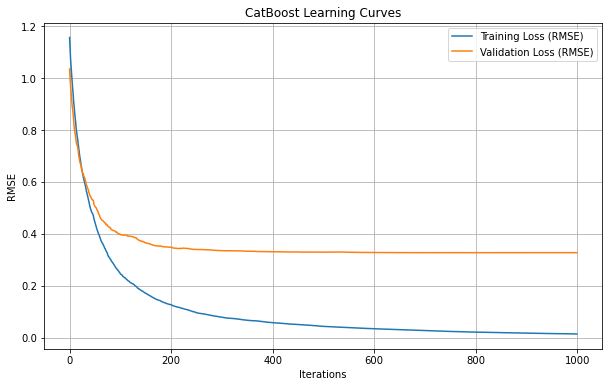

Number of iterations used: 746


In [20]:
# Fit the model and store the evaluation results
eval_results = updated_cat_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    plot=False, # Important: set this to False for manual plotting
)

# Extract the training and validation loss values
train_loss = eval_results.get_evals_result()['learn']['RMSE']
validation_loss = eval_results.get_evals_result()['validation']['RMSE']

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss (RMSE)')
plt.plot(validation_loss, label='Validation Loss (RMSE)')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('CatBoost Learning Curves')
plt.legend()
plt.grid(True)
plt.savefig('learningcurve.png')
plt.show()

#To get the number of iterations Catboost used with early stopping:
print(f"Number of iterations used: {updated_cat_model.get_best_iteration()}")

In [83]:
# Make predictions using the testing set
y_pred = updated_cat_model.predict(X)

# add to dataset
DKcom1['cb_prediction'] = y_pred

features = X.columns.tolist()

# Get feature importances
importances = updated_cat_model.feature_importances_

# Print the name and importance of each feature
for feature, importance in zip(features, importances):
    print('Feature: {:15} Importance: {}'.format(feature, importance))

r2 = r2_score(y, y_pred)
print(f'R-squared: {r2:.2f}')

Feature: LD1             Importance: 10.842128934855026
Feature: pct_reif        Importance: 6.766047729485919
Feature: LD_vac          Importance: 15.511974230396923
Feature: vcr_lagged      Importance: 14.56617260363794
Feature: HR_hosp         Importance: 4.301221613313065
Feature: week_num        Importance: 23.9165839083099
Feature: CHI_lagged      Importance: 8.08915746530658
Feature: CH_week         Importance: 6.749998328419616
Feature: Jan             Importance: 1.2496883572300248
Feature: Feb             Importance: 0.40117042205650016
Feature: Mar             Importance: 0.2024396407923598
Feature: Apr             Importance: 0.01974986378110504
Feature: May             Importance: 0.42197832410826425
Feature: Jun             Importance: 0.1952844334852164
Feature: Jul             Importance: 3.401900413761
Feature: Aug             Importance: 1.5178375886729383
Feature: Sep             Importance: 0.020311880144318218
Feature: Oct             Importance: 0.0537270948392636


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/tmp/ipykernel_210480/3408709724.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DKcom1['cb_prediction_n'] = np.exp(DKcom1['cb_prediction'])


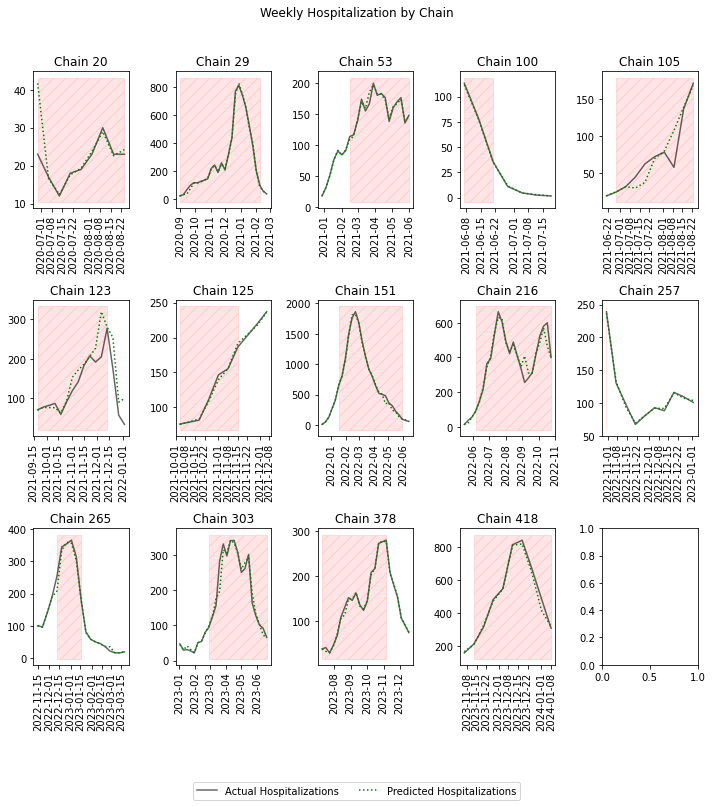

In [22]:
chains = DKcom1['chain'].unique()
DKcom1['cb_prediction_n'] = np.exp(DKcom1['cb_prediction'])
# Create a figure and axes 
fig, axs = plt.subplots(3,5, figsize=(10, 10), dpi=72)

# Flatten the axes array
axs = axs.flatten()

# Loop over each unique chain
for i, chain in enumerate(chains):
    # Filter the data for the current chain
    chain_df = DKcom1[DKcom1['chain'] == chain]
    
    # Create an area plot on the current axes
    axs[i].plot(chain_df['Date'], chain_df['weekly_hospitalization'], color="Black", alpha=0.6, label='Actual Hospitalizations')
    axs[i].plot(chain_df['Date'], chain_df['cb_prediction_n'], color="green", linestyle=':', label='Predicted Hospitalizations')
    
    # Highlight the area where 'pct' is 0.5 or higher
    high_pct = chain_df['pct'] >= 0.5
    axs[i].fill_between(chain_df['Date'][high_pct], axs[i].get_ylim()[0], 
                        axs[i].get_ylim()[1], color="red", alpha=0.1, hatch = '//')
    
    
    # Set the title for the current axes
    axs[i].set_title(f'Chain {chain}')
    
    # Rotate x-axis labels
    for label in axs[i].get_xticklabels():
        label.set_rotation(90)

# Add a title to the figure
fig.suptitle('Weekly Hospitalization by Chain', y=1.02)

# Adjust the layout
plt.tight_layout()
# Add a single legend outside the subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05),ncol=4)

#plt.savefig("simulated1.png", bbox_inches='tight')
plt.show()

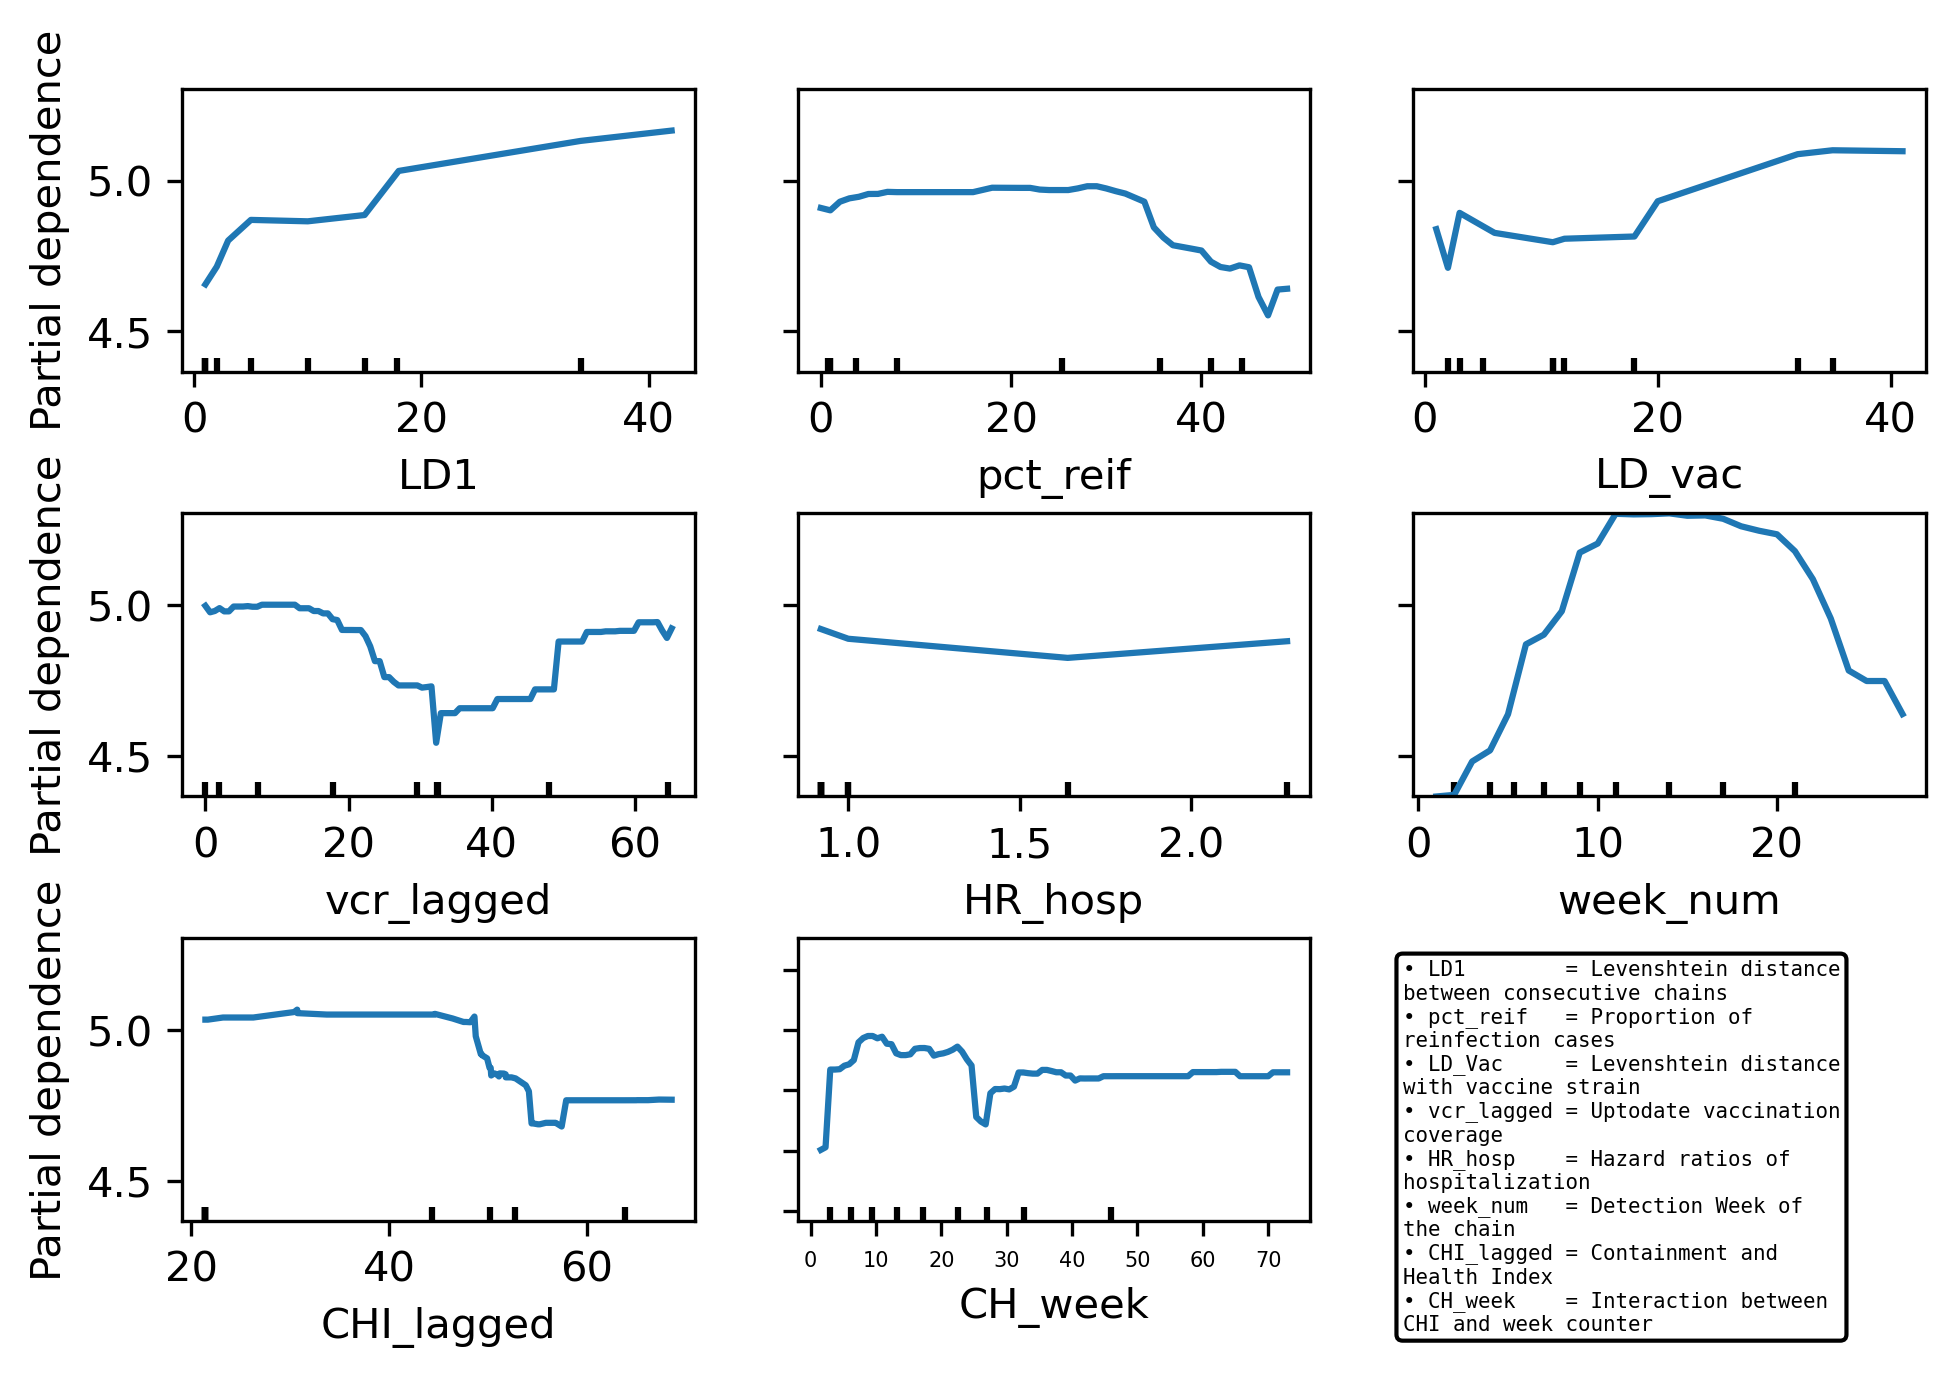

In [77]:

from matplotlib.offsetbox import AnchoredText
import textwrap
# Define the variables
first_7_variables = list(range(8))

fig, ax = plt.subplots(figsize=(7.5, 5), dpi=300)
PartialDependenceDisplay.from_estimator(updated_cat_model, X, first_7_variables, ax=ax)
plt.subplots_adjust(hspace=0.5)

lines = [
    "• LD1        = Levenshtein distance between consecutive chains",
    "• pct_reif   = Proportion of reinfection cases",
    "• LD_Vac     = Levenshtein distance with vaccine strain",
    "• vcr_lagged = Uptodate vaccination coverage",
    "• HR_hosp    = Hazard ratios of hospitalization",
    "• week_num   = Detection Week of the chain",
    "• CHI_lagged = Containment and Health Index",
    "• CH_week    = Interaction between CHI and week counter"
    ]

# Optional: wrap long lines for narrower shape
wrapped_lines = [textwrap.fill(line, width=35) for line in lines]

# Join wrapped lines into full textbox content
textbox = "\n".join(wrapped_lines)


# Add text box to upper right corner
anchored_text = AnchoredText(textbox, loc='lower right', prop={'fontsize': 6, 'family': 'monospace'}, frameon=True)
#ax.add_artist(anchored_text)
ax.text(0.7, -0.1, textbox,
        transform=ax.transAxes,
        fontsize=5,
        family='monospace',
        ha='left',
        va='bottom',
        bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.tick_params(labelsize=5)
#plt.suptitle('Partial Dependence Plots for CatBoost Model')
#fig.text(0.5, -0.05, "Supplementary Figure S12a. Partial dependence plots of selected variables showing the impact of each variable" \
#"\non CatBoost model predictions for weekly hospitalizations in Denmark,\n" \
#"while holding all other variables constant.",
#         ha='center', va='bottom', fontsize=7)
#plt.savefig('Supplementary Figure S12a.pdf', format='pdf', bbox_inches='tight')
plt.savefig('Supplementary Figure S12a.png', bbox_inches='tight')
plt.show()





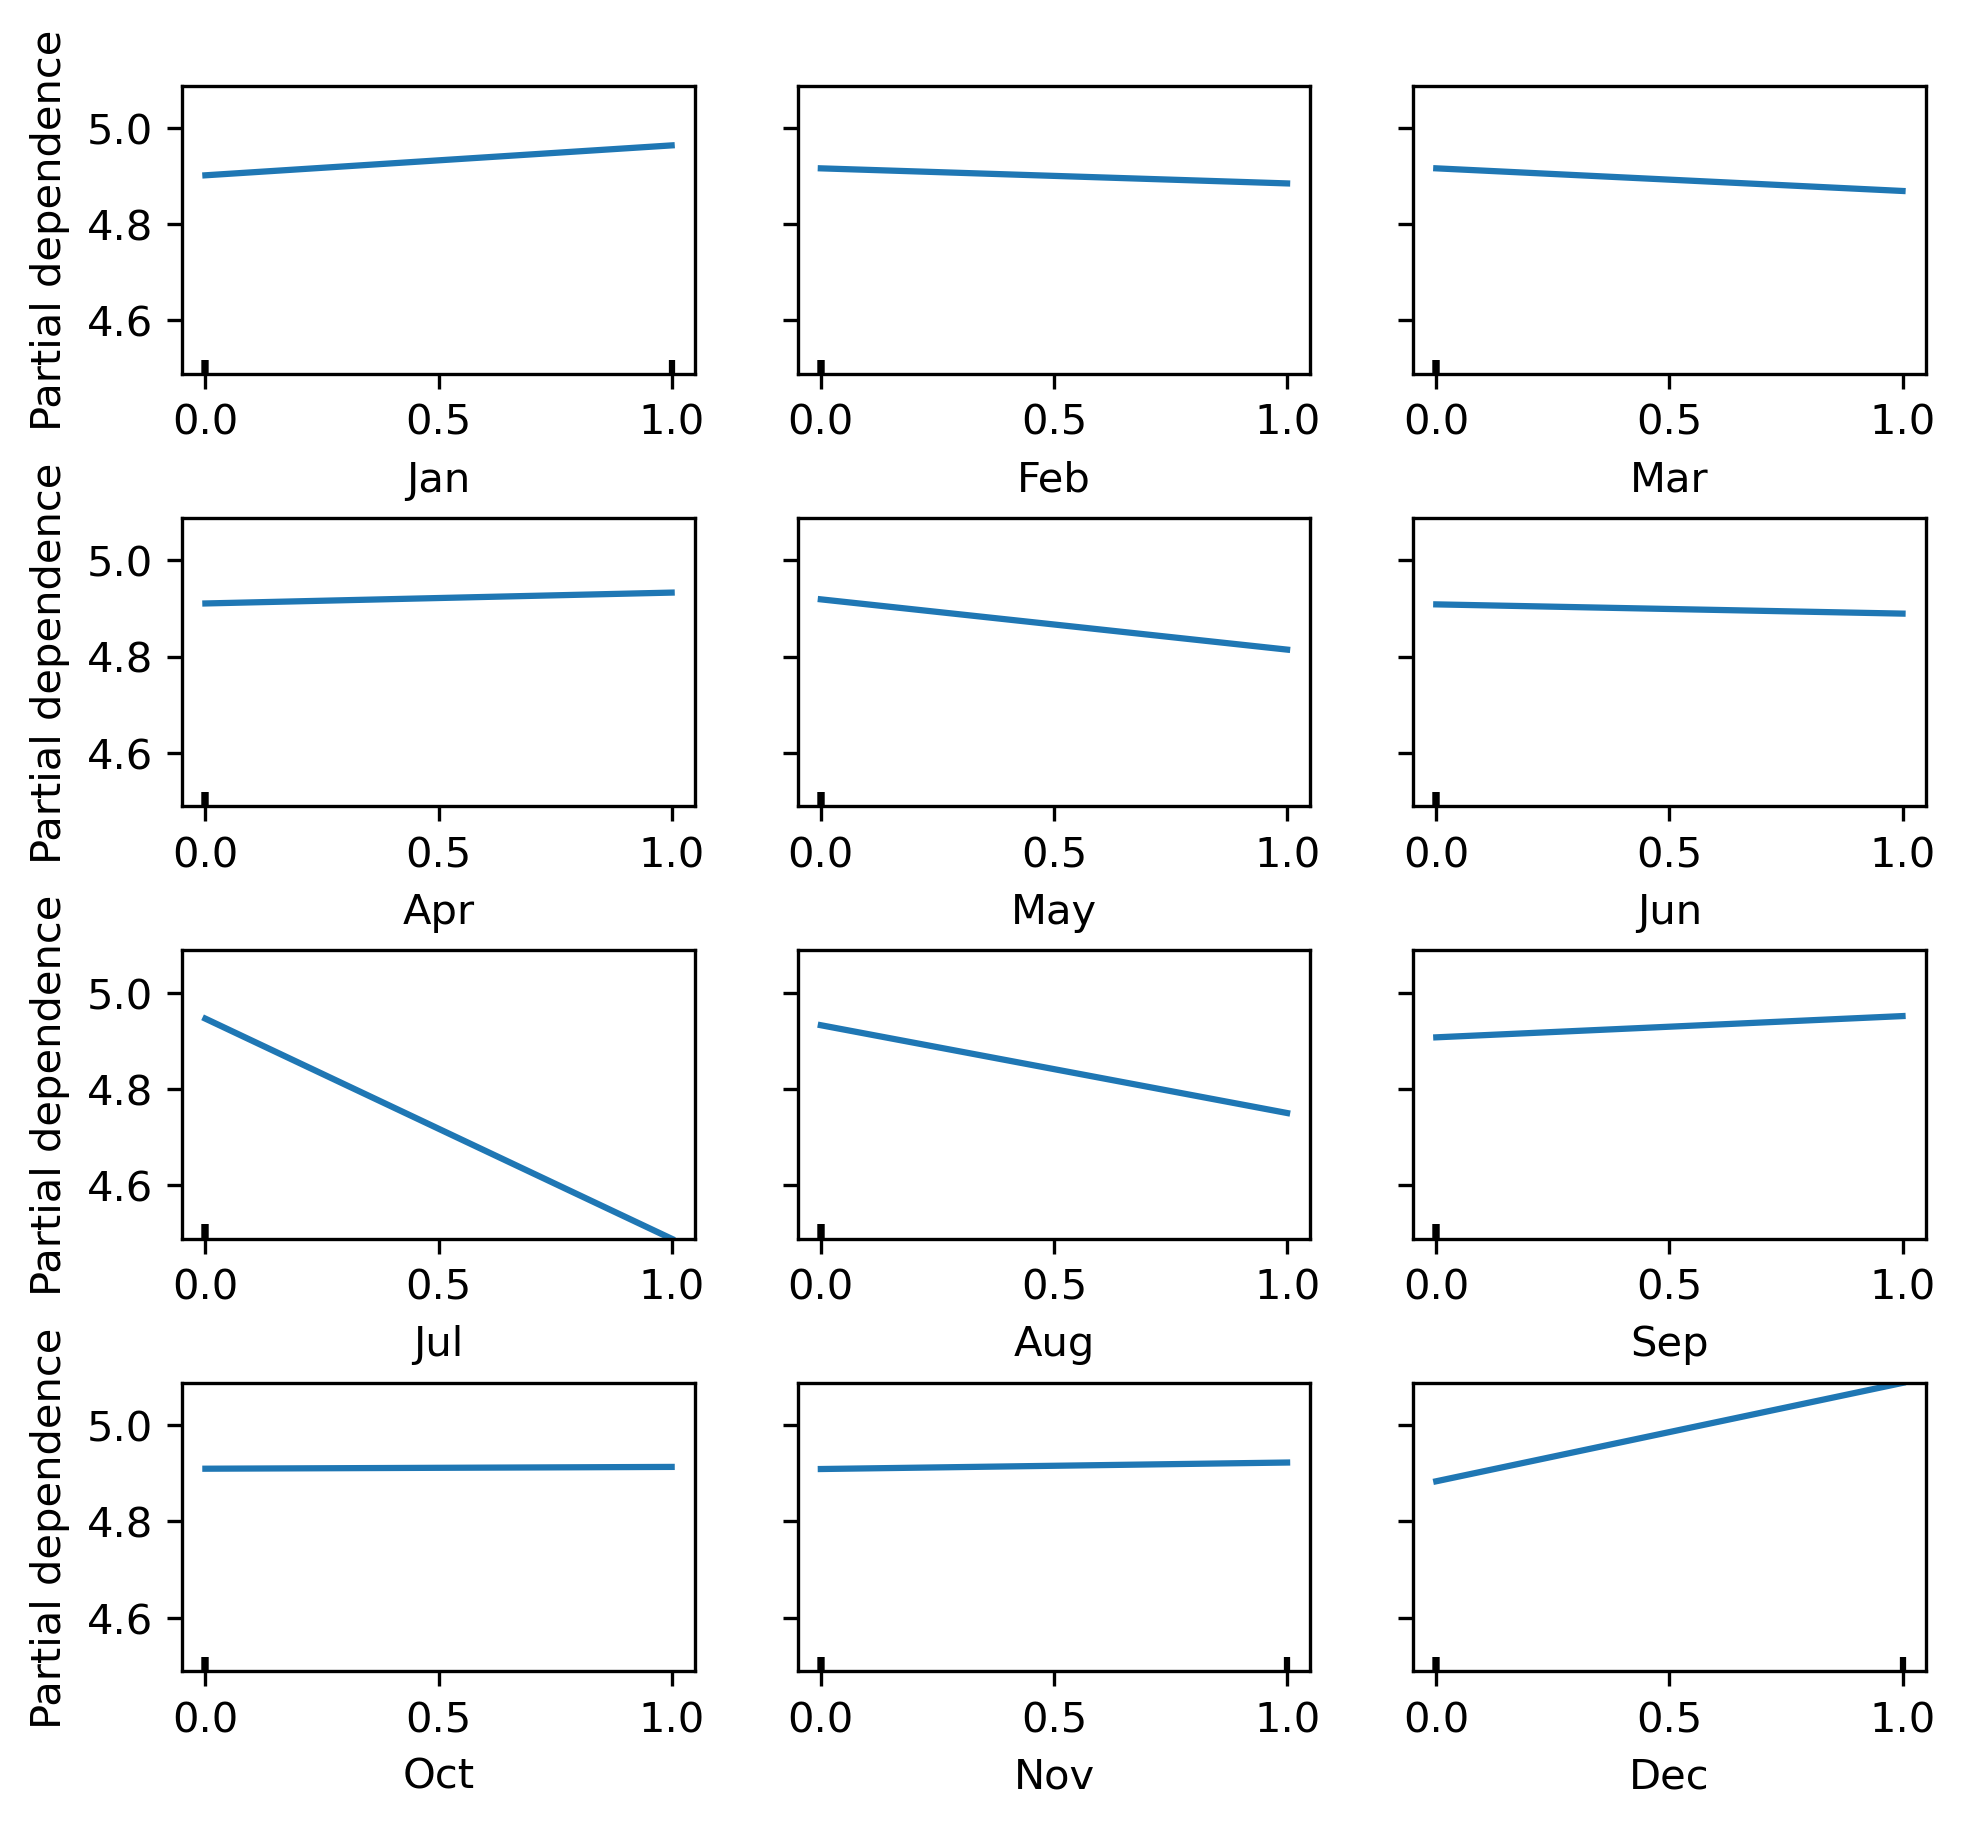

In [78]:
last_12_variables = list(range(8, 20))
#last_2 = list(range(19,21))

# Plot PDP for the last 12 variables
fig, ax = plt.subplots(figsize=(7.5, 7), dpi=300)
PartialDependenceDisplay.from_estimator(updated_cat_model, X, last_12_variables, ax=ax)
plt.subplots_adjust(hspace=0.5)
#plt.suptitle('Partial Dependence Plots for Last 12 Variables')

#plt.savefig('Supplementary Figure S13.pdf', format='pdf', bbox_inches='tight')
#plt.tick_params(labelsize=5)
plt.savefig('Supplementary Figure S12b.png', bbox_inches='tight')
plt.show()

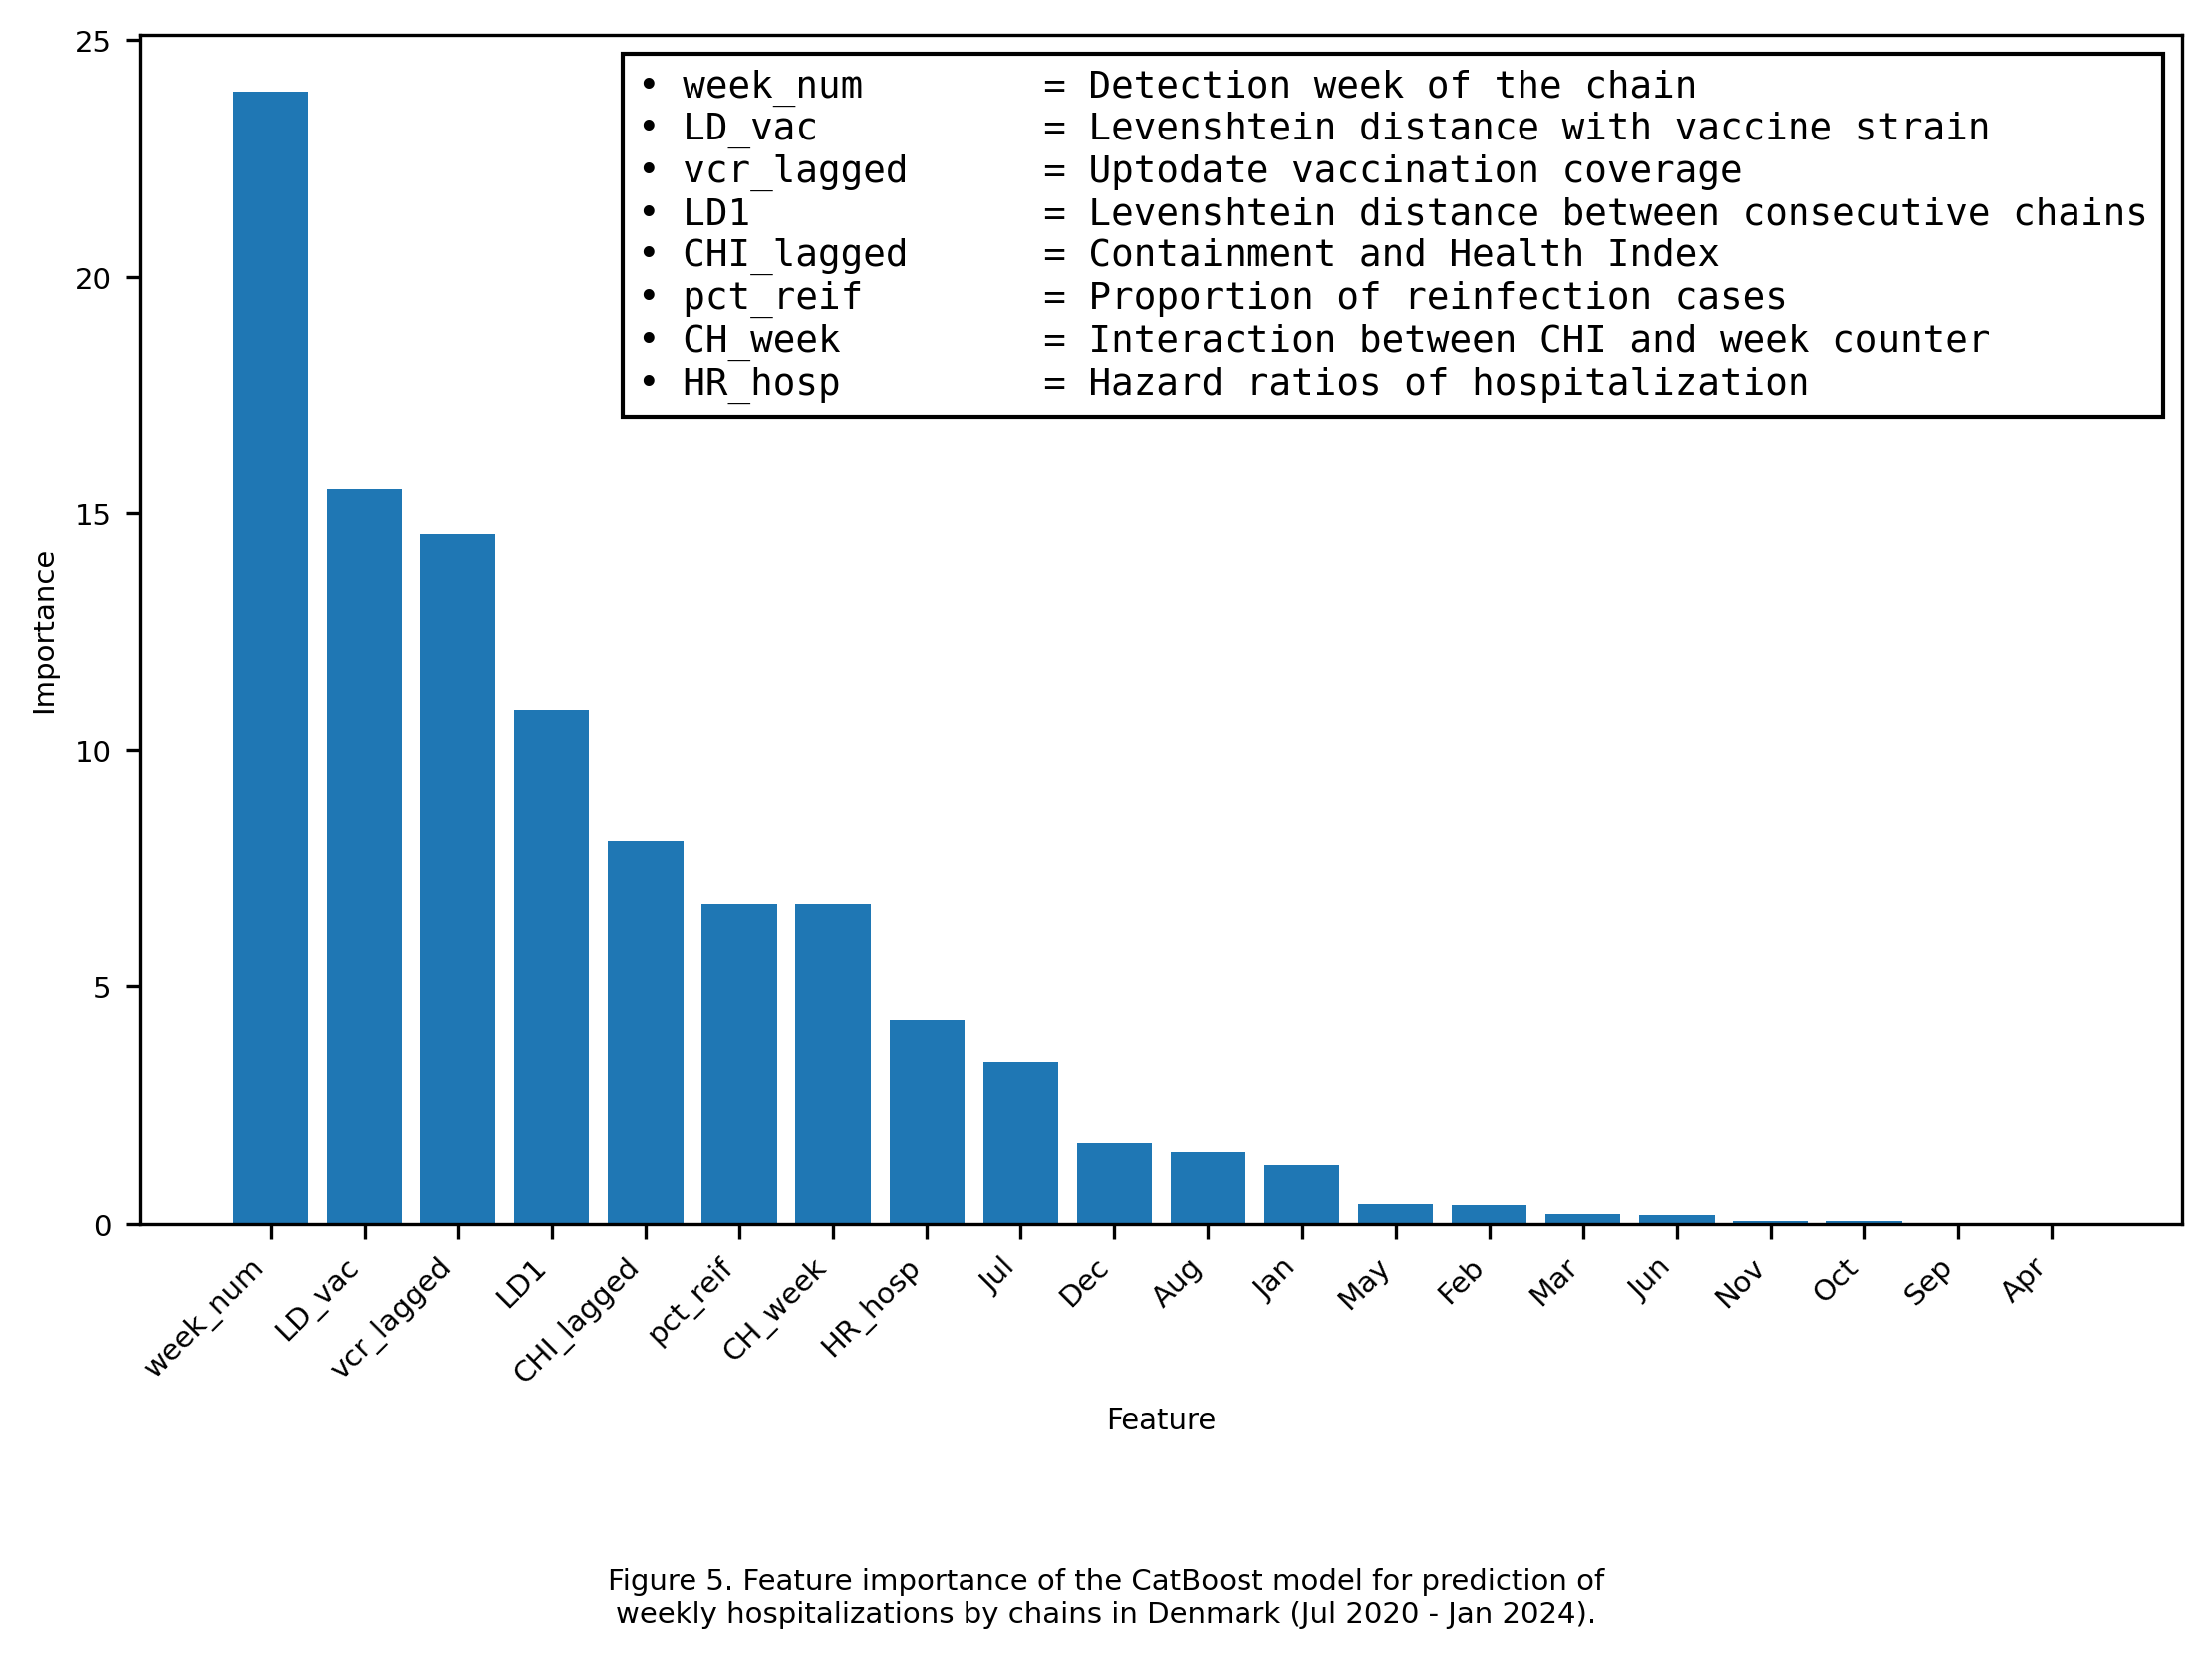

In [79]:
from matplotlib.offsetbox import AnchoredText
feature_importance = updated_cat_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easier plotting
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


# Your formatted description with aligned equal signs and bullet points
textbox = (
    "• week_num        = Detection week of the chain\n"
    "• LD_vac          = Levenshtein distance with vaccine strain\n"
    "• vcr_lagged      = Uptodate vaccination coverage\n"
    "• LD1             = Levenshtein distance between consecutive chains\n"
    "• CHI_lagged      = Containment and Health Index\n"
    "• pct_reif        = Proportion of reinfection cases\n"
    "• CH_week         = Interaction between CHI and week counter\n"
    "• HR_hosp         = Hazard ratios of hospitalization"
)


# Plot the feature importance
fig, ax = plt.subplots(figsize=(7.5, 5),dpi=300)
ax.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])

# Add text box to upper right corner
anchored_text = AnchoredText(textbox, loc='upper right', prop={'fontsize': 9, 'family': 'monospace'}, frameon=True)
ax.add_artist(anchored_text)

ax.set_xlabel('Feature', fontsize=7)
ax.set_ylabel('Importance', fontsize=7)
#plt.title('CatBoost Feature Importance', fontsize=7)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tick_params(labelsize=7)
#plt.suptitle('Partial Dependence Plots for CatBoost Model')
fig.text(0.5, -0.1, "Figure 5. Feature importance of the CatBoost model for prediction of" \
"\nweekly hospitalizations by chains in Denmark (Jul 2020 - Jan 2024).",
         ha='center', va='bottom', fontsize=7)
plt.savefig('Figure 5.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout()  # Adjust layout to prevent labels from being cut off
#plt.savefig("CB_FI.png", bbox_inches='tight')
plt.show()

In [81]:
print(feature_importance_df)

       Feature  Importance
5     week_num   23.916584
2       LD_vac   15.511974
3   vcr_lagged   14.566173
0          LD1   10.842129
6   CHI_lagged    8.089157
1     pct_reif    6.766048
7      CH_week    6.749998
4      HR_hosp    4.301222
14         Jul    3.401900
19         Dec    1.701725
15         Aug    1.517838
8          Jan    1.249688
12         May    0.421978
9          Feb    0.401170
10         Mar    0.202440
13         Jun    0.195284
18         Nov    0.070902
17         Oct    0.053727
16         Sep    0.020312
11         Apr    0.019750


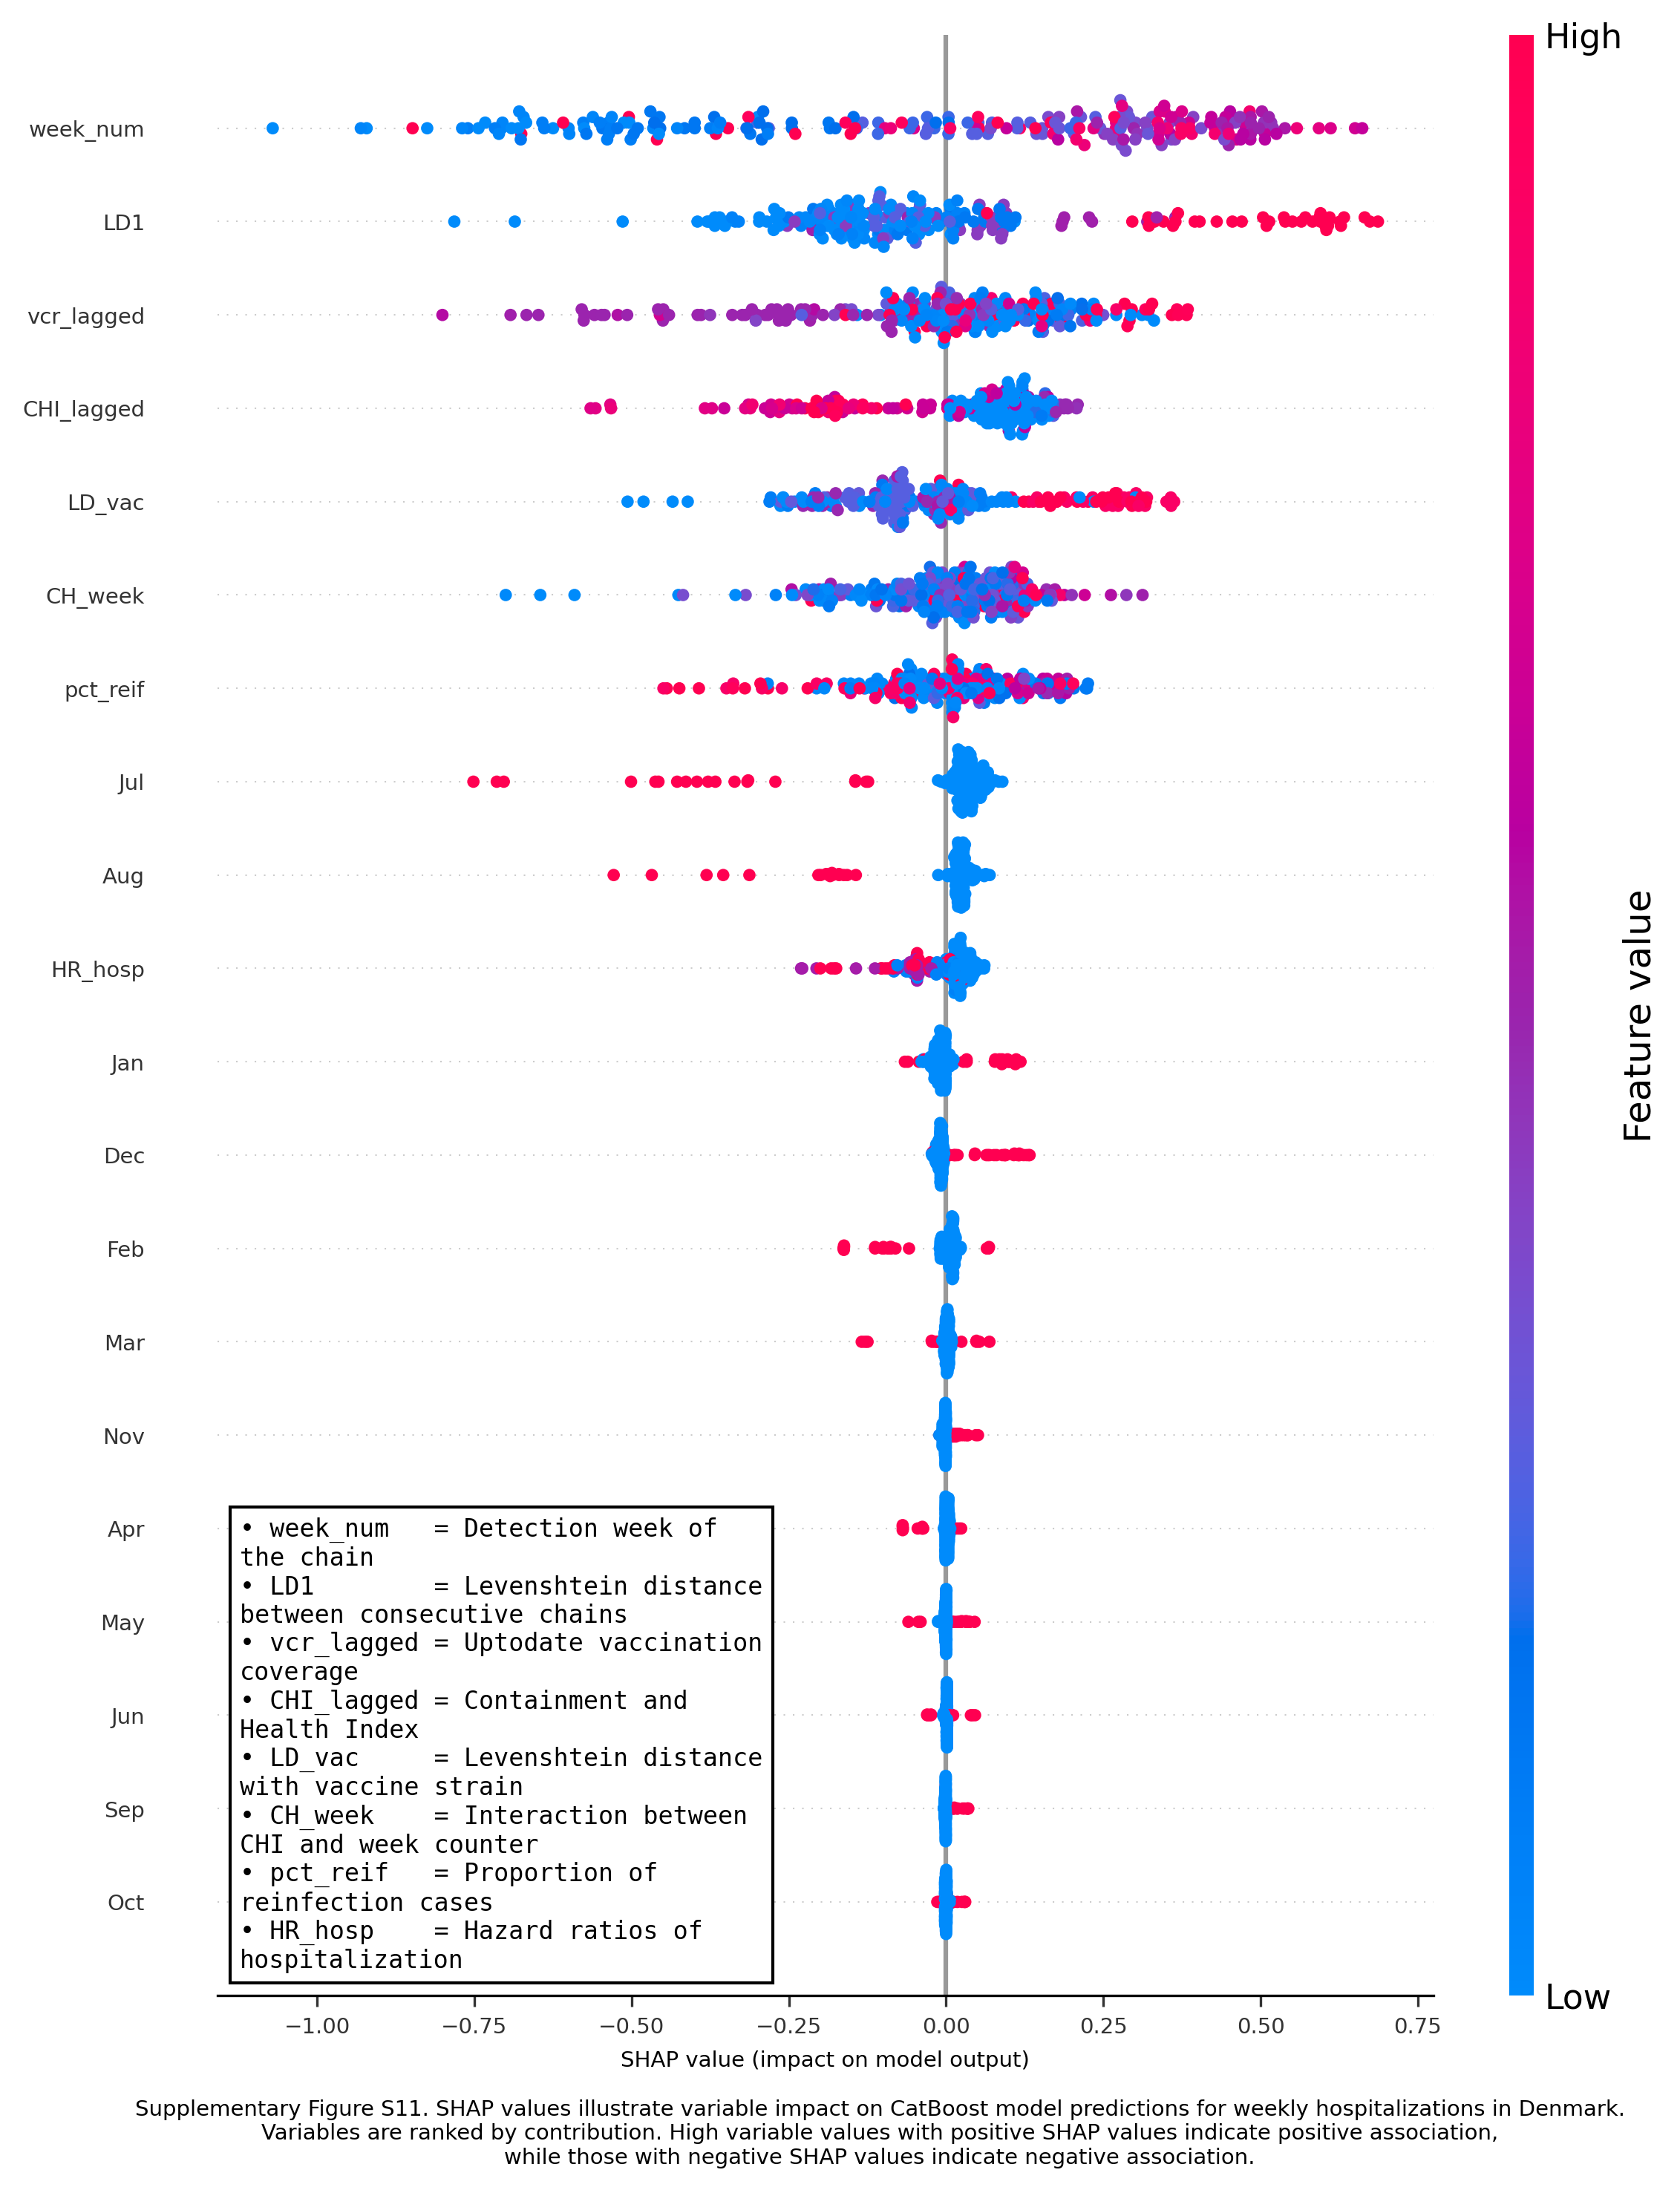

In [27]:
import shap
import textwrap
from matplotlib.offsetbox import AnchoredText

explainer = shap.TreeExplainer(updated_cat_model)
shap_values = explainer.shap_values(X)
fig = plt.figure(figsize=(7.5, 5), dpi=300)
shap.summary_plot(shap_values, X, show=False)
ax = plt.gca()


# Descriptive content
# Bullet-point lines stored individually
lines = [
    "• week_num   = Detection week of the chain",
    "• LD1        = Levenshtein distance between consecutive chains",
    "• vcr_lagged = Uptodate vaccination coverage",
    "• CHI_lagged = Containment and Health Index",
    "• LD_vac     = Levenshtein distance with vaccine strain",
    "• CH_week    = Interaction between CHI and week counter",
    "• pct_reif   = Proportion of reinfection cases",
    "• HR_hosp    = Hazard ratios of hospitalization"
]

# Optional: wrap long lines for narrower shape
wrapped_lines = [textwrap.fill(line, width=35) for line in lines]

# Join wrapped lines into full textbox content
textbox = "\n".join(wrapped_lines)
# Create and position the textbox in lower-left corner
anchored_text = AnchoredText(textbox, loc='lower left',
                             prop={'fontsize': 8, 'family': 'monospace'},
                             frameon=True, pad=0.4)

ax.add_artist(anchored_text)

plt.tick_params(labelsize=7)
#plt.ylabel("Feature", fontsize=7)
plt.xlabel("SHAP value (impact on model output)", fontsize=7)
#plt.suptitle('Partial Dependence Plots for CatBoost Model')
fig.text(0.5, -0.03, "Supplementary Figure S11. SHAP values illustrate variable impact on CatBoost model predictions for weekly hospitalizations in Denmark." \
"\nVariables are ranked by contribution. High variable values with positive SHAP values indicate positive association," \
"\nwhile those with negative SHAP values indicate negative association.",
         ha='center', va='bottom', fontsize=7)
plt.savefig('Supplementary Figure S11.pdf', format='pdf', bbox_inches='tight')
plt.savefig('Supplementary Figure S11.png', bbox_inches='tight')

# Finalize layout and show
plt.tight_layout()
plt.show()

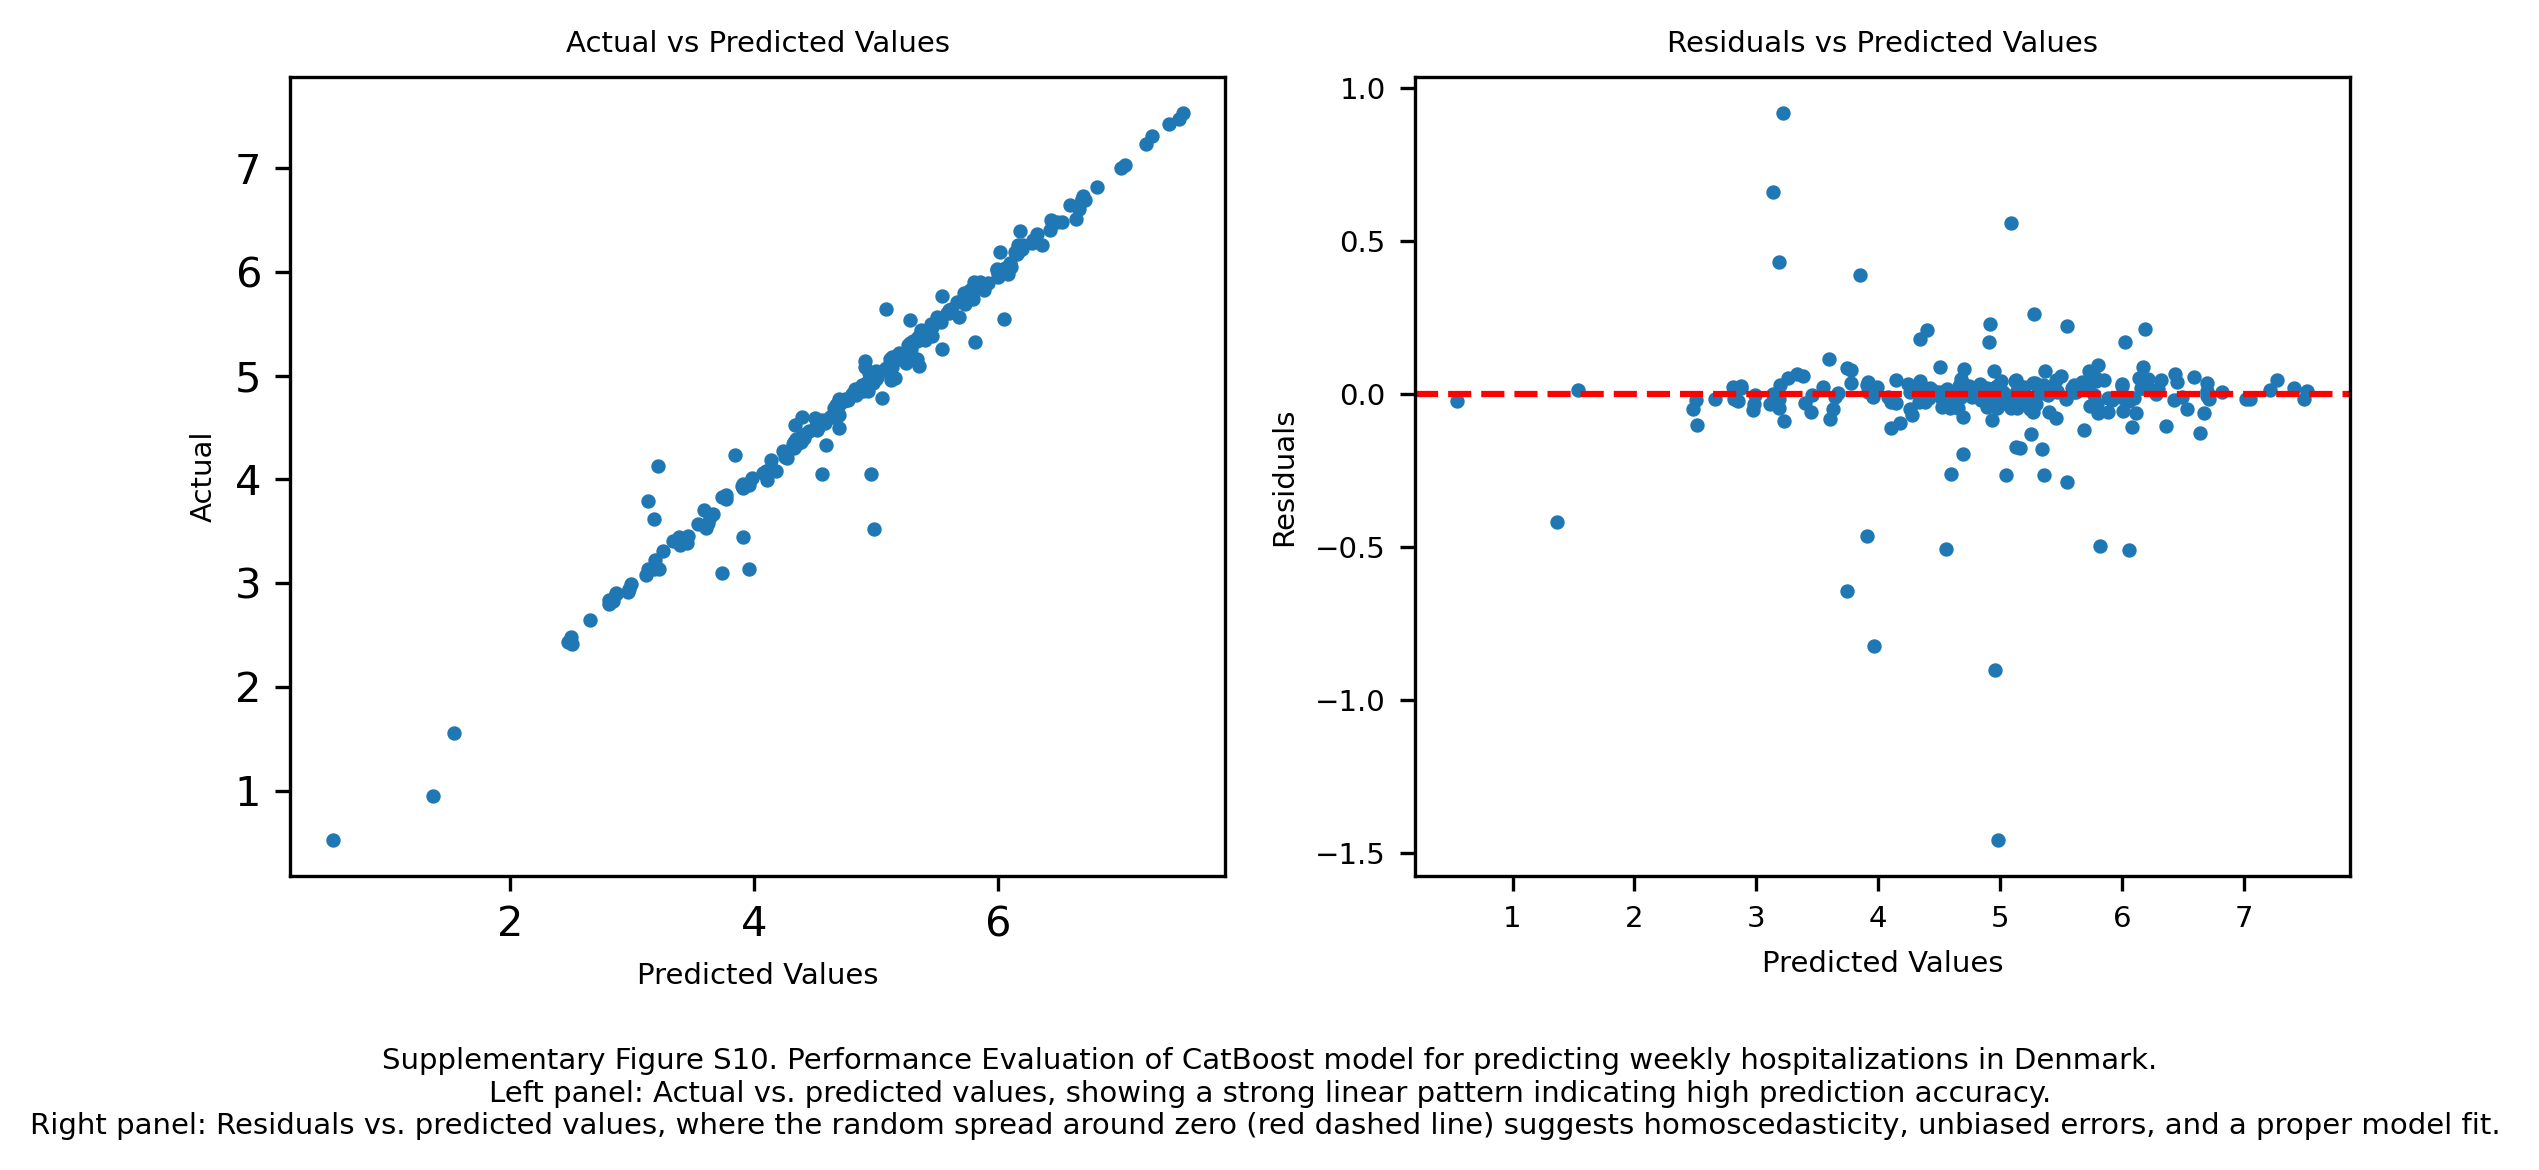

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5, 3.5), dpi=300)

# Plot the prediction
ax1.scatter(y_pred, y, s=6)
ax1.set_xlabel('Predicted Values', fontsize=7)
ax1.set_ylabel('Actual', fontsize=7)
ax1.set_title('Actual vs Predicted Values', fontsize=7)

# Calculate residuals
residuals = y - y_pred 

# Plot the residuals
ax2.scatter(y_pred, residuals, s=6)
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_xlabel('Predicted Values', fontsize=7)
ax2.set_ylabel('Residuals', fontsize=7)
ax2.set_title('Residuals vs Predicted Values', fontsize=7)

plt.tick_params(labelsize=7)
fig.text(0.5, -0.1, "Supplementary Figure S10. Performance Evaluation of CatBoost model for predicting weekly hospitalizations in Denmark." \
"\nLeft panel: Actual vs. predicted values, showing a strong linear pattern indicating high prediction accuracy." \
"\nRight panel: Residuals vs. predicted values, where the random spread around zero (red dashed line) suggests homoscedasticity, unbiased errors, and a proper model fit. ",
         ha='center', va='bottom', fontsize=7)
plt.savefig('Supplementary Figure S10.pdf', format='pdf', bbox_inches='tight')

plt.tight_layout()
plt.savefig("Model performance.png", bbox_inches='tight')
plt.show()

In [31]:
modified_data = DKcom1.copy(deep=True)
modified_data['Cumu_Hospitalization'] = modified_data.groupby('chain')['weekly_hospitalization'].cumsum()


In [32]:
# Convert the 'Date' column to datetime
#modified_data[['CH_week']] = scaler.fit_transform(modified_data[['CH_week']])


X_modified = modified_data[['LD1','pct_reif', 'LD_vac','vcr_lagged','HR_hosp','week_num', 'CHI_lagged','CH_week',
           'Jan', 'Feb', 'Mar', 'Apr', 'May',  'Jun', 'Jul','Aug',  'Sep' ,'Oct','Nov','Dec']]

    
log_predictions = updated_cat_model.predict(X_modified)
    
# Transform predictions back to the original scale
predictions = np.exp(log_predictions)
    
# Add predictions to the modified data
modified_data['simulation_2024'] = predictions
modified_data['simulation_2024_log'] = log_predictions

# Print the modified data with new columns
print(modified_data.head())

   LD1  pct_reif  LD_vac  vcr_lagged  HR_hosp  week_num  CHI_lagged  \
3    1       2.0       2         0.0      1.0         1   52.380000   
4    1       6.0       2         0.0      1.0         2   52.380000   
5    1       2.0       2         0.0      1.0         3   50.680000   
6    1       2.0       2         0.0      1.0         4   51.022857   
7    1       2.0       2         0.0      1.0         5   51.790000   

   LD_interaction  pct  log_weekly_hospitalization  ...  CHI_lagged2  \
3               2  1.0                    3.135494  ...    52.380000   
4               2  1.0                    2.833213  ...    52.380000   
5               2  1.0                    2.484907  ...    50.680000   
6               2  1.0                    2.890372  ...    51.022857   
7               2  1.0                    2.944439  ...    51.790000   

  vcr_lagged2 sq_weekly_hospitalization  chain2    CH_week2  cb_prediction  \
3         0.0                  4.795832      20   52.380000   

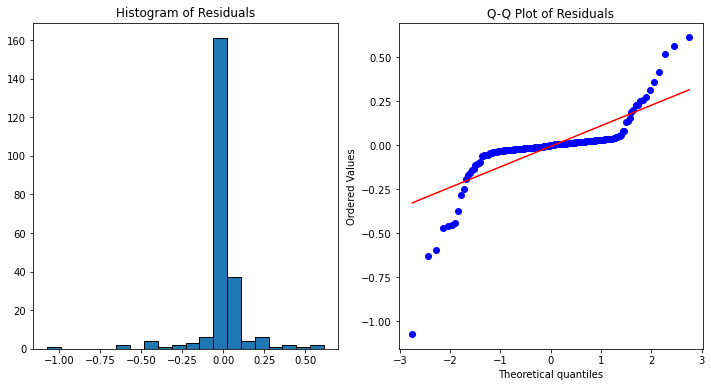

Mean of Residuals: -0.005958668006103198
Standard Deviation of Residuals: 0.14824973526009688
Residuals Range: -1.0732454224625831 to 0.6129451701682278


In [33]:
residuals = modified_data["log_weekly_hospitalization"] - modified_data["simulation_2024_log"]

# Visualizations
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(residuals, bins=20, edgecolor='black')
plt.title("Histogram of Residuals")

plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")

plt.show()

# Descriptive Statistics
print(f"Mean of Residuals: {np.mean(residuals)}")
print(f"Standard Deviation of Residuals: {np.std(residuals)}")
print(f"Residuals Range: {np.min(residuals)} to {np.max(residuals)}")

In [34]:
from scipy.stats import shapiro

print(np.isnan(residuals).any())  # Check for NaNs
print(np.isinf(residuals).any())  # Check for infinities

# Example: residuals
stat, p_value = shapiro(residuals)

print(f"Test Statistic: {stat}")
print(f"P-value: {p_value}")

if p_value > 0.05:
    print("Residuals appear to be normally distributed (fail to reject null hypothesis).")
else:
    print("Residuals do not appear to be normally distributed (reject null hypothesis).")


False
False
Test Statistic: 0.6211854219436646
P-value: 2.155234888468567e-22
Residuals do not appear to be normally distributed (reject null hypothesis).


In [35]:
n_bootstraps = 1000  # Or more for more stable CIs

model_params = updated_cat_model.get_params()

# 2. Parallelized Bootstrapping:
def bootstrap_iteration(i, X_train, y_train, X_modified, model_params):
    X_resampled, y_resampled = resample(X_train, y_train, replace=True, random_state=i)
    bootstrap_model = CatBoostRegressor(**model_params) # Use model_params
    bootstrap_model.fit(X_resampled, y_resampled)
    return bootstrap_model.predict(X_modified)

def get_bootstrap_predictions(X_train, y_train, X_modified, n_bootstraps, model_params):
    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count()) #Use all cores
    results = [pool.apply_async(bootstrap_iteration, (i, X_train, y_train, X_modified, model_params)) for i in range(n_bootstraps)]
    predictions = [result.get() for result in results]
    pool.close()
    pool.join()
    return np.array(predictions)

predictions = get_bootstrap_predictions(X_train, y_train, X_modified, n_bootstraps, model_params)


# 3. Calculate Confidence Intervals (Vectorized):
alpha = 0.05  # For 95% CI
lower_bound = np.quantile(predictions, alpha / 2, axis=0)
upper_bound = np.quantile(predictions, 1 - alpha / 2, axis=0)

# Calculate confidence intervals
modified_data['lower_2024_log'] = lower_bound
modified_data['upper_2024_log'] = upper_bound

modified_data['lower_2024'] = np.exp(modified_data['lower_2024_log'])
modified_data['upper_2024'] = np.exp(modified_data['upper_2024_log'])

modified_data['Cumu_lower_2024'] = modified_data.groupby('chain')['lower_2024'].cumsum()
modified_data['Cumu_upper_2024'] = modified_data.groupby('chain')['upper_2024'].cumsum()

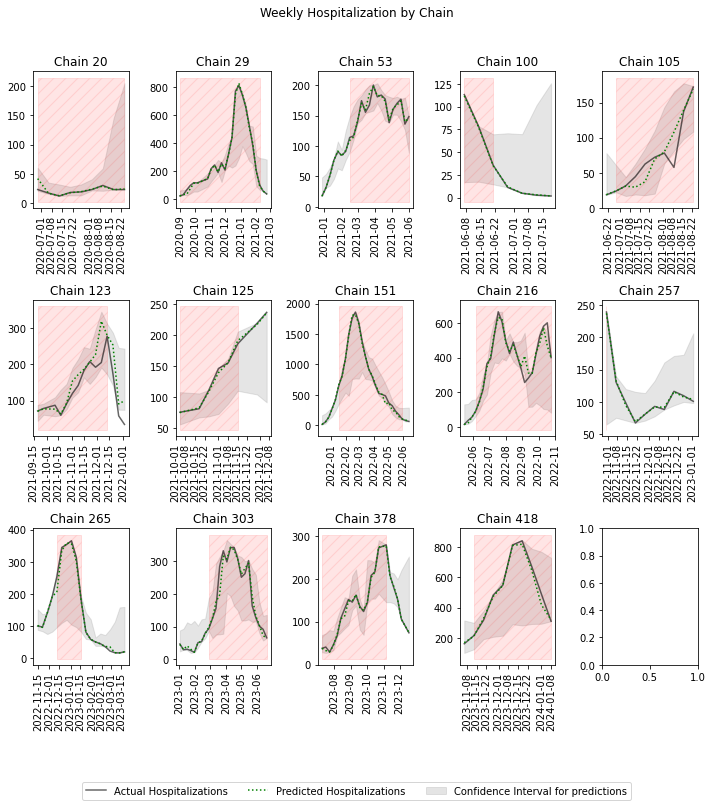

In [36]:
# Create a figure and axes 
fig, axs = plt.subplots(3,5, figsize=(10, 10), dpi=72)

# Flatten the axes array
axs = axs.flatten()

# Loop over each unique chain
for i, chain in enumerate(chains):
    # Filter the data for the current chain
    chain_df = modified_data[modified_data['chain'] == chain]
    
    # Create an area plot on the current axes
    axs[i].plot(chain_df['Date'], chain_df['weekly_hospitalization'], color="Black", alpha=0.6, label='Actual Hospitalizations')
    axs[i].plot(chain_df['Date'], chain_df['simulation_2024'], color="green", linestyle=':', label='Predicted Hospitalizations')
    axs[i].fill_between(chain_df['Date'], chain_df['lower_2024'], chain_df['upper_2024'], alpha=0.2, color='gray', 
                        label='Confidence Interval for predictions')
    # Highlight the area where 'pct' is 0.5 or higher
    high_pct = chain_df['pct'] >= 0.5
    axs[i].fill_between(chain_df['Date'][high_pct], axs[i].get_ylim()[0], 
                        axs[i].get_ylim()[1], color="red", alpha=0.1, hatch = '//')
    
    
    # Set the title for the current axes
    axs[i].set_title(f'Chain {chain}')
    
    # Rotate x-axis labels
    for label in axs[i].get_xticklabels():
        label.set_rotation(90)

# Add a title to the figure
fig.suptitle('Weekly Hospitalization by Chain', y=1.02)

# Adjust the layout
plt.tight_layout()
# Add a single legend outside the subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05),ncol=4)

plt.savefig("CB_simulated2.png", bbox_inches='tight')
plt.show()

In [37]:
modified_data['LD_vac'] = np.where(modified_data['LD_vac'] >=15, 5, modified_data['LD_vac'])


X_modified = modified_data[['LD1','pct_reif', 'LD_vac','vcr_lagged','HR_hosp','week_num', 'CHI_lagged','CH_week',
           'Jan', 'Feb', 'Mar', 'Apr', 'May',  'Jun', 'Jul','Aug',  'Sep' ,'Oct','Nov','Dec']]

log_predictions = updated_cat_model.predict(X_modified)

# Transform predictions back to the original scale
predictions = np.exp(log_predictions)

# Add predictions to the modified data
modified_data['simulation_LDvac'] = predictions
modified_data['simulation_LDvac_log'] = log_predictions

modified_data['LD_vac'] = modified_data['LD_vac2']



In [38]:
model_params = updated_cat_model.get_params()
n_bootstraps = 1000  # Or more for more stable CIs

# 2. Parallelized Bootstrapping:
def bootstrap_iteration(i, X_train, y_train, X_modified, model_params):
    X_resampled, y_resampled = resample(X_train, y_train, replace=True, random_state=i)
    bootstrap_model = CatBoostRegressor(**model_params) # Use model_params
    bootstrap_model.fit(X_resampled, y_resampled)
    return bootstrap_model.predict(X_modified)

def get_bootstrap_predictions(X_train, y_train, X_modified, n_bootstraps, model_params):
    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count()) #Use all cores
    results = [pool.apply_async(bootstrap_iteration, (i, X_train, y_train, X_modified, model_params)) for i in range(n_bootstraps)]
    predictions = [result.get() for result in results]
    pool.close()
    pool.join()
    return np.array(predictions)


predictions = get_bootstrap_predictions(X_train, y_train, X_modified, n_bootstraps, model_params)


# 3. Calculate Confidence Intervals (Vectorized):
alpha = 0.05  # For 95% CI
lower_bound = np.quantile(predictions, alpha / 2, axis=0)
upper_bound = np.quantile(predictions, 1 - alpha / 2, axis=0)

In [39]:

# Calculate confidence intervals
modified_data['lower_LDvac_log'] = lower_bound
modified_data['upper_LDvac_log'] = upper_bound

modified_data['lower_LDvac'] = np.exp(modified_data['lower_LDvac_log'])
modified_data['upper_LDvac'] = np.exp(modified_data['upper_LDvac_log'])

modified_data['Cumu_lower_LDvac'] = modified_data.groupby('chain')['lower_LDvac'].cumsum()
modified_data['Cumu_upper_LDvac'] = modified_data.groupby('chain')['upper_LDvac'].cumsum()


# Print the modified data with new columns
print(modified_data.head())

   LD1  pct_reif  LD_vac  vcr_lagged  HR_hosp  week_num  CHI_lagged  \
3    1       2.0       2         0.0      1.0         1   52.380000   
4    1       6.0       2         0.0      1.0         2   52.380000   
5    1       2.0       2         0.0      1.0         3   50.680000   
6    1       2.0       2         0.0      1.0         4   51.022857   
7    1       2.0       2         0.0      1.0         5   51.790000   

   LD_interaction  pct  log_weekly_hospitalization  ...  Cumu_lower_2024  \
3               2  1.0                    3.135494  ...        20.813296   
4               2  1.0                    2.833213  ...        36.358490   
5               2  1.0                    2.484907  ...        48.351254   
6               2  1.0                    2.890372  ...        61.392737   
7               2  1.0                    2.944439  ...        74.465978   

  Cumu_upper_2024 simulation_LDvac  simulation_LDvac_log  lower_LDvac_log  \
3       60.409649        41.714131     

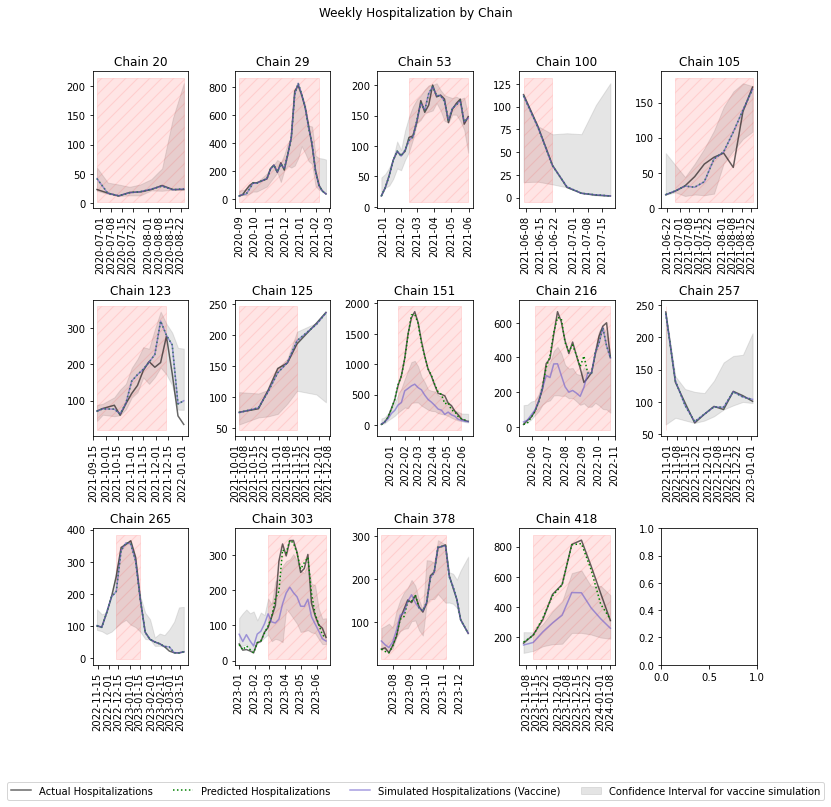

In [40]:
chains = modified_data['chain'].unique()
# Create a figure and axes 
fig, axs = plt.subplots(3,5, figsize=(10, 10), dpi=72)

# Flatten the axes array
axs = axs.flatten()

# Loop over each unique chain
for i, chain in enumerate(chains):
    # Filter the data for the current chain
    chain_df = modified_data[modified_data['chain'] == chain]
    
    # Create an area plot on the current axes
    axs[i].plot(chain_df['Date'], chain_df['weekly_hospitalization'], color="Black", alpha=0.6, label='Actual Hospitalizations')
    axs[i].plot(chain_df['Date'], chain_df['simulation_2024'], color="green", linestyle=':', label='Predicted Hospitalizations')
    axs[i].plot(chain_df['Date'], chain_df['simulation_LDvac'], c="Slateblue",alpha=0.6, label='Simulated Hospitalizations (Vaccine)')
    axs[i].fill_between(chain_df['Date'], chain_df['lower_LDvac'], chain_df['upper_LDvac'], alpha=0.2, color='gray', 
                        label='Confidence Interval for vaccine simulation')
    
    # Highlight the area where 'pct' is 0.5 or higher
    high_pct = chain_df['pct'] >= 0.5
    axs[i].fill_between(chain_df['Date'][high_pct], axs[i].get_ylim()[0], 
                        axs[i].get_ylim()[1], color="red", alpha=0.1, hatch = '//')
    
    
    # Set the title for the current axes
    axs[i].set_title(f'Chain {chain}')
    
    # Rotate x-axis labels
    for label in axs[i].get_xticklabels():
        label.set_rotation(90)

# Add a title to the figure
fig.suptitle('Weekly Hospitalization by Chain', y=1.02)

# Adjust the layout
plt.tight_layout()
# Add a single legend outside the subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05),ncol=4)

plt.savefig("simulatedLDvac.png", bbox_inches='tight')
plt.show()

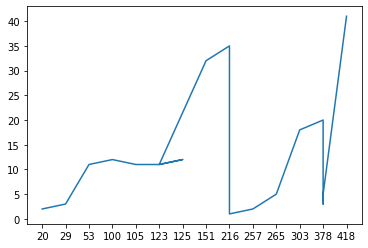

In [41]:
plt.plot(modified_data['chain'], modified_data['LD_vac'])

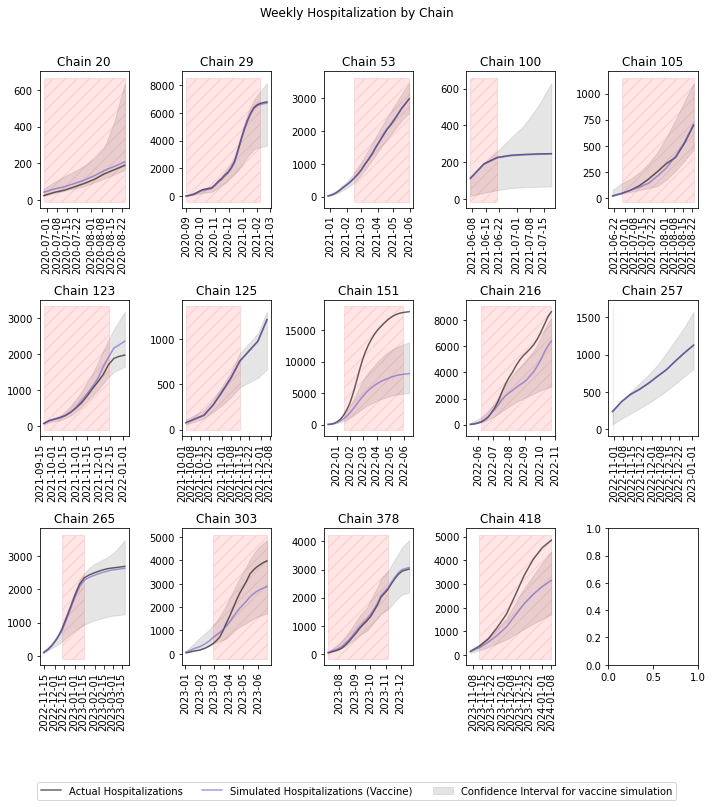

In [42]:
#modified_data.loc[modified_data['chain'] == 'Simulation', 'weekly_hospitalization'] = modified_data['simulation_2024']
modified_data['Cumu_Hospitalization_LD_vac'] = modified_data.groupby('chain')['simulation_LDvac'].cumsum()
modified_data['Cumulative_Hospitalization'] = modified_data.groupby('chain')['weekly_hospitalization'].cumsum()

chains = modified_data['chain'].unique()
# Create a figure and axes 
fig, axs = plt.subplots(3,5, figsize=(10, 10), dpi=72)

# Flatten the axes array
axs = axs.flatten()

# Loop over each unique chain
for i, chain in enumerate(chains):
    # Filter the data for the current chain
    chain_df = modified_data[modified_data['chain'] == chain]
    
    # Create an area plot on the current axes
    axs[i].plot(chain_df['Date'], chain_df['Cumulative_Hospitalization'], color="Black", alpha=0.6, label='Actual Hospitalizations')
    #axs[i].plot(chain_df['Date'], chain_df['simulation_2024'], color="green", linestyle=':', label='Predicted Hospitalizations')
    axs[i].plot(chain_df['Date'], chain_df['Cumu_Hospitalization_LD_vac'], c="Slateblue",alpha=0.6, label='Simulated Hospitalizations (Vaccine)')
    axs[i].fill_between(chain_df['Date'], chain_df['Cumu_lower_LDvac'], chain_df['Cumu_upper_LDvac'], alpha=0.2, color='gray', 
                        label='Confidence Interval for vaccine simulation')
    
    # Highlight the area where 'pct' is 0.5 or higher
    high_pct = chain_df['pct'] >= 0.5
    axs[i].fill_between(chain_df['Date'][high_pct], axs[i].get_ylim()[0], 
                        axs[i].get_ylim()[1], color="red", alpha=0.1, hatch = '//')
    
    
    # Set the title for the current axes
    axs[i].set_title(f'Chain {chain}')
    
    # Rotate x-axis labels
    for label in axs[i].get_xticklabels():
        label.set_rotation(90)

# Add a title to the figure
fig.suptitle('Weekly Hospitalization by Chain', y=1.02)

# Adjust the layout
plt.tight_layout()
# Add a single legend outside the subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05),ncol=4)

#plt.savefig("simulated1.png", bbox_inches='tight')
plt.show()

In [43]:
def update_stringency_index(modified_data):
    # Update the first 2 weeks (assuming each week is 7 days)
    modified_data.loc[(modified_data['week_num'] >= 6) & (modified_data['week_num'] < 15), 'CHI_lagged'] = 68.57
    # Update the next 2 weeks
    modified_data.loc[(modified_data['week_num'] >= 15), 'CHI_lagged'] = 68.57
    return modified_data

modified_data = update_stringency_index(modified_data)
modified_data['CH_week'] = modified_data['CHI_lagged'] * modified_data['week_num']
modified_data['CH_week'] = scaler.fit_transform(modified_data[['CH_week']])
#modified_data[['reinf_LD1', 'vcr_LDvac']] = scaler.fit_transform(modified_data[['reinf_LD1', 'vcr_LDvac']])

X_modified = modified_data[['LD1','pct_reif', 'LD_vac','vcr_lagged','HR_hosp','week_num', 'CHI_lagged','CH_week',
           'Jan', 'Feb', 'Mar', 'Apr', 'May',  'Jun', 'Jul','Aug',  'Sep' ,'Oct','Nov','Dec']]
    
    
    
log_predictions = updated_cat_model.predict(X_modified)
    
# Transform predictions back to the original scale
predictions = np.exp(log_predictions)
    
# Add predictions to the modified data
modified_data['predicted_y_SI_newt'] = predictions
modified_data['predicted_y_SI_newt_log'] = log_predictions

modified_data['Cumu_Hospitalization_simulated_2024'] = modified_data.groupby('chain')['simulation_2024'].cumsum()
modified_data['Cumu_Hospitalization_simulated_SI_newt'] = modified_data.groupby('chain')['predicted_y_SI_newt'].cumsum()

modified_data['CHI_lagged'] = modified_data['CHI_lagged2']
modified_data['CH_week'] = modified_data['CHI_lagged'] * modified_data['week_num']

In [44]:

predictions = get_bootstrap_predictions(X_train, y_train, X_modified, n_bootstraps, model_params)


# 3. Calculate Confidence Intervals (Vectorized):
alpha = 0.05  # For 95% CI
lower_bound = np.quantile(predictions, alpha / 2, axis=0)
upper_bound = np.quantile(predictions, 1 - alpha / 2, axis=0)

modified_data['lower_SI_Newt_log'] = lower_bound
modified_data['upper_SI_Newt_log'] = upper_bound

modified_data['lower_SI_Newt'] = np.exp(modified_data['lower_SI_Newt_log'])
modified_data['upper_SI_Newt'] = np.exp(modified_data['upper_SI_Newt_log'])
modified_data['Cumu_lci_SI_newt'] = modified_data.groupby('chain')['lower_SI_Newt'].cumsum()
modified_data['Cumu_uci_SI_newt'] = modified_data.groupby('chain')['upper_SI_Newt'].cumsum()

print(modified_data)

     LD1  pct_reif  LD_vac  vcr_lagged  HR_hosp  week_num  CHI_lagged  \
3      1       2.0       2    0.000000     1.00         1   52.380000   
4      1       6.0       2    0.000000     1.00         2   52.380000   
5      1       2.0       2    0.000000     1.00         3   50.680000   
6      1       2.0       2    0.000000     1.00         4   51.022857   
7      1       2.0       2    0.000000     1.00         5   51.790000   
..   ...       ...     ...         ...      ...       ...         ...   
228    2      40.0       5   18.480633     0.92        22   21.430000   
235   42      40.0      41   18.480633     0.92         7   21.430000   
236   42      34.0      41   18.757490     0.92         8   21.430000   
237   42      40.0      41   18.921380     0.92         9   21.430000   
238   42      39.0      41   18.939095     0.92        10   21.430000   

     LD_interaction       pct  log_weekly_hospitalization  ...  \
3                 2  1.000000                    3.135494

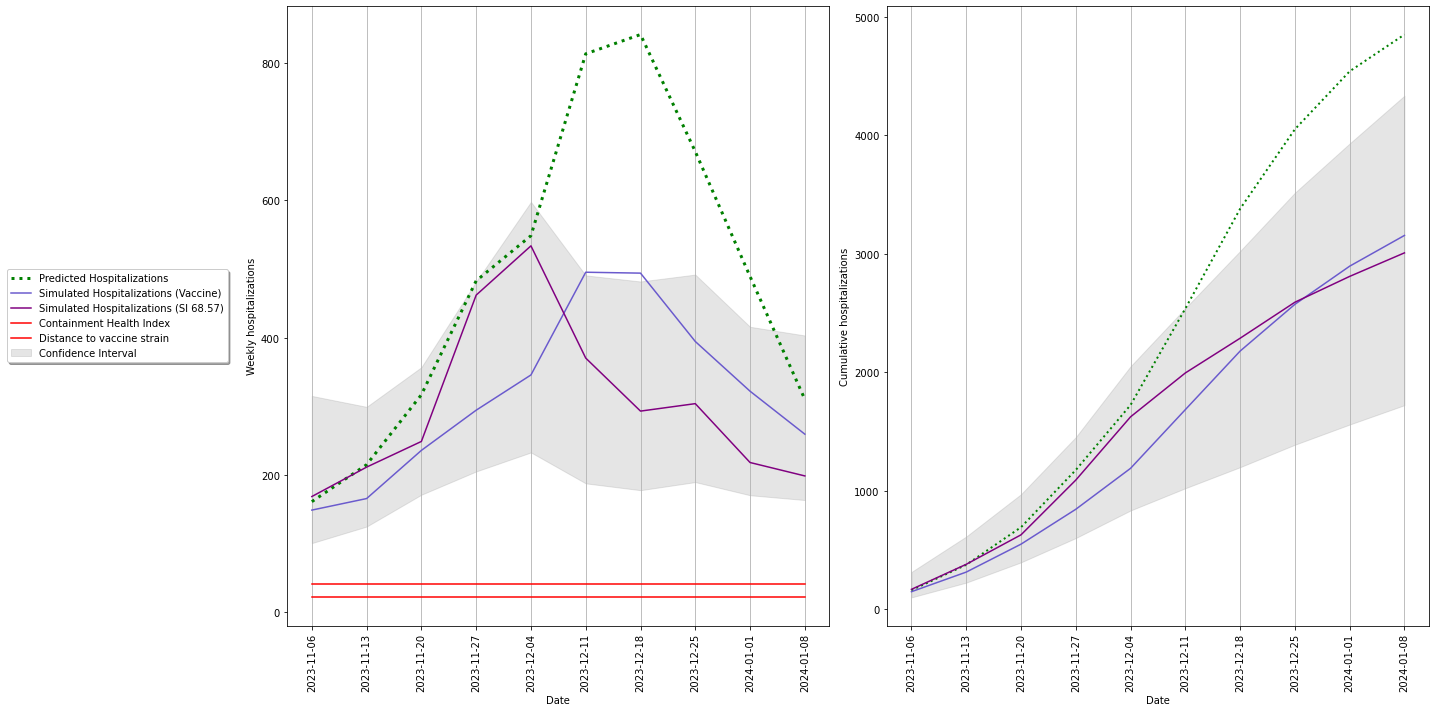

In [45]:

modified_data2 = modified_data[modified_data['chain']== '418']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), dpi=72)
ax1.plot(modified_data2['Date'], modified_data2['weekly_hospitalization'], color="green",linestyle=':', linewidth = 3, label='Predicted Hospitalizations')
ax1.plot(modified_data2['Date'], modified_data2['simulation_LDvac'], c="Slateblue", label='Simulated Hospitalizations (Vaccine)')
ax1.plot(modified_data2['Date'], modified_data2['predicted_y_SI_newt'], c="purple", label='Simulated Hospitalizations (SI 68.57)')
ax1.plot(modified_data2['Date'], modified_data2['CHI_lagged'], c="red", label='Containment Health Index')
ax1.plot(modified_data2['Date'], modified_data2['LD_vac'], c="red", label='Distance to vaccine strain')
ax1.fill_between(modified_data2['Date'], modified_data2['lower_SI_Newt'], modified_data2['upper_SI_Newt'], alpha=0.2, color='gray', 
                        label='Confidence Interval')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=1))
ax1.legend(loc ='center right', bbox_to_anchor=(-0.1, 0.5), fancybox=True, shadow=True) 
ax1.grid(axis='x') 
ax1.set_xlabel('Date') 
ax1.set_ylabel('Weekly hospitalizations')

ax2.plot(modified_data2['Date'], modified_data2['Cumulative_Hospitalization'],linestyle=':', color="green", linewidth = 2, label='Predicted Hospitalizations')
ax2.plot(modified_data2['Date'], modified_data2['Cumu_Hospitalization_LD_vac'], c="Slateblue", label='Simulations (Distance to Vaccine)')
ax2.plot(modified_data2['Date'], modified_data2['Cumu_Hospitalization_simulated_SI_newt'], c="purple", label='Simulations (SI 68.57)')
ax2.fill_between(modified_data2['Date'], modified_data2['Cumu_lci_SI_newt'], modified_data2['Cumu_uci_SI_newt'], alpha=0.2, color='gray', 
                        label='Confidence Interval for vaccine simulation')
#ax2.legend(loc ='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True) 
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
# Set major locator to start weeks from Monday 
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=1))
ax2.grid(axis='x') 
ax2.set_xlabel('Date') 
ax2.set_ylabel('Cumulative hospitalizations')


# Rotate date labels for better readability
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)

# Ensure the subplots are the same size
plt.tight_layout()

# Show the plot
plt.show()

In [46]:
modified_data['CHI_lagged'] = modified_data['CHI_lagged2']
def update_stringency_index(modified_data):
    
    modified_data.loc[(modified_data['week_num'] >= 6) & (modified_data['week_num'] < 15), 'CHI_lagged'] = 68.57
    return modified_data

modified_data = update_stringency_index(modified_data)
modified_data['CH_week'] = modified_data['CHI_lagged'] * modified_data['week_num']
modified_data['CH_week'] = scaler.fit_transform(modified_data[['CH_week']])
#modified_data[['reinf_LD1', 'vcr_LDvac']] = scaler.fit_transform(modified_data[['reinf_LD1', 'vcr_LDvac']])

X_modified = modified_data[['LD1','pct_reif', 'LD_vac','vcr_lagged','HR_hosp','week_num', 'CHI_lagged','CH_week',
           'Jan', 'Feb', 'Mar', 'Apr', 'May',  'Jun', 'Jul','Aug',  'Sep' ,'Oct','Nov','Dec']]
    

log_predictions = updated_cat_model.predict(X_modified)
    
# Transform predictions back to the original scale
predictions = np.exp(log_predictions)
    
# Add predictions to the modified data
modified_data['predicted_y_SI_new'] = predictions
modified_data['predicted_y_SI_new_log'] = log_predictions

modified_data['Cumu_Hospitalization_simulated_SI_new'] = modified_data.groupby('chain')['predicted_y_SI_new'].cumsum()



In [47]:


predictions = get_bootstrap_predictions(X_train, y_train, X_modified, n_bootstraps, model_params)


# 3. Calculate Confidence Intervals (Vectorized):
alpha = 0.05  # For 95% CI
lower_bound = np.quantile(predictions, alpha / 2, axis=0)
upper_bound = np.quantile(predictions, 1 - alpha / 2, axis=0)

# Calculate confidence intervals
modified_data['lower_SI_New_log'] = lower_bound
modified_data['upper_SI_New_log'] = upper_bound

modified_data['lower_SI_New'] = np.exp(modified_data['lower_SI_New_log'])
modified_data['upper_SI_New'] = np.exp(modified_data['upper_SI_New_log'])

modified_data['Cumu_lci_SI_new'] = modified_data.groupby('chain')['lower_SI_New'].cumsum()
modified_data['Cumu_uci_SI_new'] = modified_data.groupby('chain')['upper_SI_New'].cumsum()

print(modified_data)

     LD1  pct_reif  LD_vac  vcr_lagged  HR_hosp  week_num  CHI_lagged  \
3      1       2.0       2    0.000000     1.00         1   52.380000   
4      1       6.0       2    0.000000     1.00         2   52.380000   
5      1       2.0       2    0.000000     1.00         3   50.680000   
6      1       2.0       2    0.000000     1.00         4   51.022857   
7      1       2.0       2    0.000000     1.00         5   51.790000   
..   ...       ...     ...         ...      ...       ...         ...   
228    2      40.0       5   18.480633     0.92        22   21.430000   
235   42      40.0      41   18.480633     0.92         7   68.570000   
236   42      34.0      41   18.757490     0.92         8   68.570000   
237   42      40.0      41   18.921380     0.92         9   68.570000   
238   42      39.0      41   18.939095     0.92        10   68.570000   

     LD_interaction       pct  log_weekly_hospitalization  ...  \
3                 2  1.000000                    3.135494

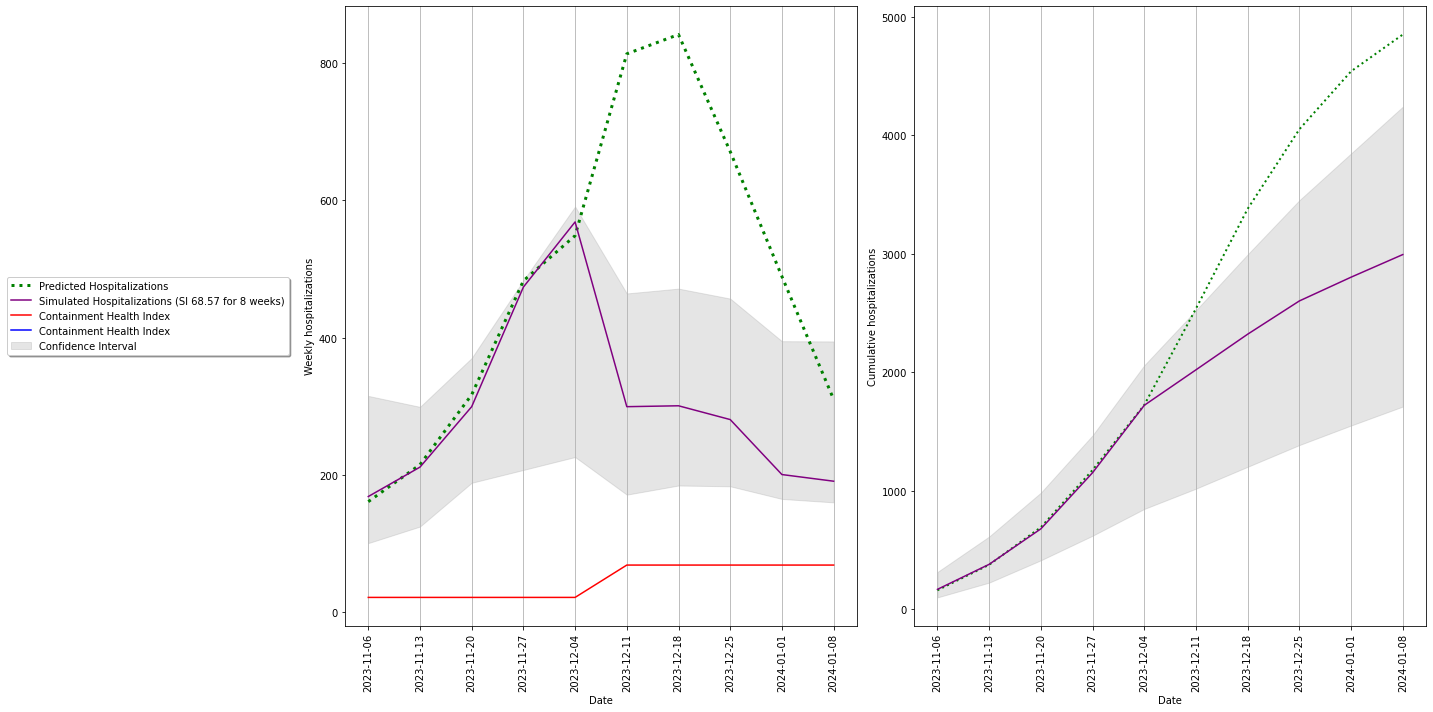

In [48]:
modified_data2 = modified_data[modified_data['chain']== '418']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), dpi=72)
ax1.plot(modified_data2['Date'], modified_data2['weekly_hospitalization'], color="green",linestyle=':', linewidth = 3, label='Predicted Hospitalizations')
#ax1.plot(modified_data2['Date'], modified_data2['simulation_LDvac'], c="Slateblue", label='Simulated Hospitalizations (Vaccine)')
ax1.plot(modified_data2['Date'], modified_data2['predicted_y_SI_new'], c="purple", label='Simulated Hospitalizations (SI 68.57 for 8 weeks)')
ax1.plot(modified_data2['Date'], modified_data2['CHI_lagged'], c="red", label='Containment Health Index')
ax1.plot(modified_data2['Date'], modified_data2['ContainmentHealthIndex_Average'], c="blue", label='Containment Health Index')
ax1.fill_between(modified_data2['Date'], modified_data2['lower_SI_New'], modified_data2['upper_SI_New'], alpha=0.2, color='gray', 
                        label='Confidence Interval')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=1))
ax1.legend(loc ='center right', bbox_to_anchor=(-0.1, 0.5), fancybox=True, shadow=True) 
ax1.grid(axis='x') 
ax1.set_xlabel('Date') 
ax1.set_ylabel('Weekly hospitalizations')

ax2.plot(modified_data2['Date'], modified_data2['Cumulative_Hospitalization'],linestyle=':', color="green", linewidth = 2, label='Predicted Hospitalizations')
#ax2.plot(modified_data2['Date'], modified_data2['Cumu_Hospitalization_LD_vac'], c="Slateblue", label='Simulations (Distance to Vaccine)')
ax2.plot(modified_data2['Date'], modified_data2['Cumu_Hospitalization_simulated_SI_new'], c="purple", label='Simulations (SI 68.57 for 8 weeks)')
#ax2.legend(loc ='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True) 
ax2.fill_between(modified_data2['Date'], modified_data2['Cumu_lci_SI_new'], modified_data2['Cumu_uci_SI_new'], alpha=0.2, color='gray', 
                        label='Confidence Interval')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
# Set major locator to start weeks from Monday 
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=1))
ax2.grid(axis='x') 
ax2.set_xlabel('Date') 
ax2.set_ylabel('Cumulative hospitalizations')


# Rotate date labels for better readability
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)

# Ensure the subplots are the same size
plt.tight_layout()

# Show the plot
plt.show()

In [49]:
modified_data['vcr_lagged'] = modified_data['vcr_lagged2']

def update_vcr(modified_data):
    # Update the after 8 weeks
    modified_data.loc[(modified_data['week_num'] >= 6) , 'vcr_lagged'] *= 2
    modified_data.loc[modified_data['vcr_lagged'] > 96, 'vcr_lagged'] = 96
    return modified_data


modified_data = update_vcr(modified_data)


X_modified = modified_data[['LD1','pct_reif', 'LD_vac','vcr_lagged','HR_hosp','week_num', 'CHI_lagged','CH_week',#'reinf_LD1',
           'Jan', 'Feb', 'Mar', 'Apr', 'May',  'Jun', 'Jul','Aug',  'Sep' ,'Oct','Nov','Dec']]
    
    
    
log_predictions = updated_cat_model.predict(X_modified)
    
# Transform predictions back to the original scale
predictions = np.exp(log_predictions)
    
# Add predictions to the modified data
modified_data['predicted_y_SI_new2'] = predictions
modified_data['predicted_y_SI_new2_log'] = log_predictions
modified_data['Cumu_Hospitalization_simulated_SI_new2'] = modified_data.groupby('chain')['predicted_y_SI_new2'].cumsum()



In [50]:

predictions = get_bootstrap_predictions(X_train, y_train, X_modified, n_bootstraps, model_params)


# 3. Calculate Confidence Intervals (Vectorized):
alpha = 0.05  # For 95% CI
lower_bound = np.quantile(predictions, alpha / 2, axis=0)
upper_bound = np.quantile(predictions, 1 - alpha / 2, axis=0)

# Calculate confidence intervals
modified_data['lower_SI_New2_log'] = lower_bound
modified_data['upper_SI_New2_log'] = upper_bound

modified_data['lower_SI_New2'] = np.exp(modified_data['lower_SI_New2_log'])
modified_data['upper_SI_New2'] = np.exp(modified_data['upper_SI_New2_log'])

modified_data['Cumu_lci_SI_new2'] = modified_data.groupby('chain')['lower_SI_New2'].cumsum()
modified_data['Cumu_uci_SI_new2'] = modified_data.groupby('chain')['upper_SI_New2'].cumsum()

print(modified_data)

     LD1  pct_reif  LD_vac  vcr_lagged  HR_hosp  week_num  CHI_lagged  \
3      1       2.0       2    0.000000     1.00         1   52.380000   
4      1       6.0       2    0.000000     1.00         2   52.380000   
5      1       2.0       2    0.000000     1.00         3   50.680000   
6      1       2.0       2    0.000000     1.00         4   51.022857   
7      1       2.0       2    0.000000     1.00         5   51.790000   
..   ...       ...     ...         ...      ...       ...         ...   
228    2      40.0       5   36.961266     0.92        22   21.430000   
235   42      40.0      41   36.961266     0.92         7   68.570000   
236   42      34.0      41   37.514981     0.92         8   68.570000   
237   42      40.0      41   37.842760     0.92         9   68.570000   
238   42      39.0      41   37.878191     0.92        10   68.570000   

     LD_interaction       pct  log_weekly_hospitalization  ...  \
3                 2  1.000000                    3.135494

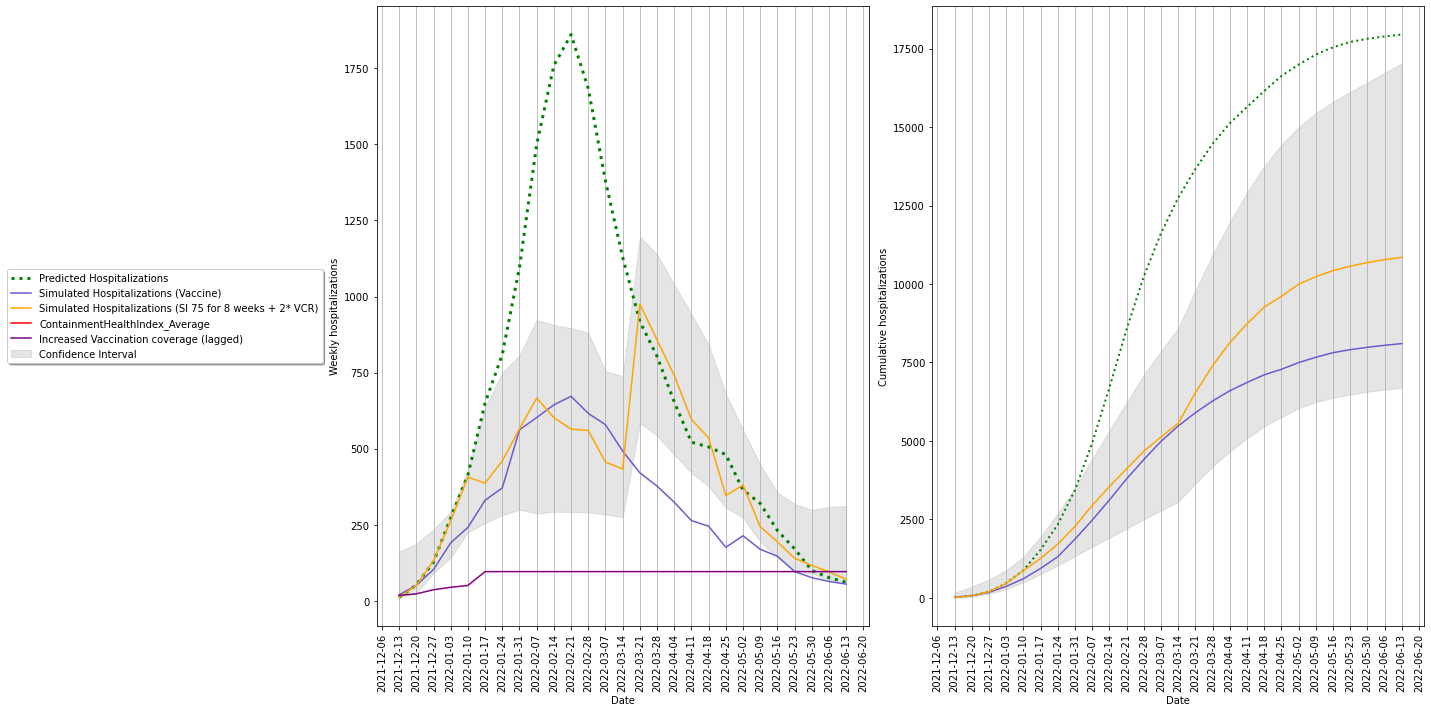

In [51]:
modified_data2 = modified_data[modified_data['chain']== '151']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), dpi=72)
ax1.plot(modified_data2['Date'], modified_data2['weekly_hospitalization'], color="green",linestyle=':', linewidth = 3, label='Predicted Hospitalizations')
ax1.plot(modified_data2['Date'], modified_data2['simulation_LDvac'], c="Slateblue", label='Simulated Hospitalizations (Vaccine)')
ax1.plot(modified_data2['Date'], modified_data2['predicted_y_SI_new2'], c="orange", label='Simulated Hospitalizations (SI 75 for 8 weeks + 2* VCR)')
ax1.plot(modified_data2['Date'], modified_data2['ContainmentHealthIndex_Average'], c="red", label='ContainmentHealthIndex_Average')
ax1.plot(modified_data2['Date'], modified_data2['vcr_lagged'], c="purple", label='Increased Vaccination coverage (lagged)')
ax1.fill_between(modified_data2['Date'], modified_data2['lower_SI_New2'], modified_data2['upper_SI_New2'], alpha=0.2, color='gray', 
                        label='Confidence Interval')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=1))
ax1.legend(loc ='center right', bbox_to_anchor=(-0.1, 0.5), fancybox=True, shadow=True) 
ax1.grid(axis='x') 
ax1.set_xlabel('Date') 
ax1.set_ylabel('Weekly hospitalizations')

ax2.plot(modified_data2['Date'], modified_data2['Cumulative_Hospitalization'],linestyle=':', color="green", linewidth = 2, label='Predicted Hospitalizations')
ax2.plot(modified_data2['Date'], modified_data2['Cumu_Hospitalization_LD_vac'], c="Slateblue", label='Simulations (Distance to Vaccine)')
ax2.plot(modified_data2['Date'], modified_data2['Cumu_Hospitalization_simulated_SI_new2'], c="orange", label='Simulations (SI 75 for 8 weeks + 2* VCR)')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
ax2.fill_between(modified_data2['Date'], modified_data2['Cumu_lci_SI_new2'], modified_data2['Cumu_uci_SI_new2'], alpha=0.2, color='gray', 
                        label='Confidence Interval')
# Set major locator to start weeks from Monday 
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=1))
ax2.grid(axis='x') 
ax2.set_xlabel('Date') 
ax2.set_ylabel('Cumulative hospitalizations')


# Rotate date labels for better readability
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)

# Ensure the subplots are the same size
plt.tight_layout()

# Show the plot
plt.show()

In [52]:
modified_data['CHI_lagged'] = modified_data['CHI_lagged2']
modified_data['CH_week'] = modified_data['CHI_lagged'] * modified_data['week_num']
modified_data['CH_week'] = scaler.fit_transform(modified_data[['CH_week']])

#modified_data2['vcr_uptodate'] = modified_data2['vcr_uptodate2']

X_modified = modified_data[['LD1','pct_reif', 'LD_vac','vcr_lagged','HR_hosp','week_num', 'CHI_lagged','CH_week',#'reinf_LD1',
           'Jan', 'Feb', 'Mar', 'Apr', 'May',  'Jun', 'Jul','Aug',  'Sep' ,'Oct','Nov','Dec']]
    
    
log_predictions = updated_cat_model.predict(X_modified)
    
# Transform predictions back to the original scale
predictions = np.exp(log_predictions)
    
# Add predictions to the modified data
modified_data['predicted_y_SI_new3'] = predictions
modified_data['predicted_y_SI_new3_log'] = log_predictions
modified_data['Cumu_Hospitalization_simulated_SI_new3'] = modified_data.groupby('chain')['predicted_y_SI_new3'].cumsum()



In [53]:

predictions = get_bootstrap_predictions(X_train, y_train, X_modified, n_bootstraps, model_params)


# 3. Calculate Confidence Intervals (Vectorized):
alpha = 0.05  # For 95% CI
lower_bound = np.quantile(predictions, alpha / 2, axis=0)
upper_bound = np.quantile(predictions, 1 - alpha / 2, axis=0)

# Calculate confidence intervals
modified_data['lower_SI_New3_log'] = lower_bound
modified_data['upper_SI_New3_log'] = upper_bound

modified_data['lower_SI_New3'] = np.exp(modified_data['lower_SI_New3_log'])
modified_data['upper_SI_New3'] = np.exp(modified_data['upper_SI_New3_log'])

modified_data['Cumu_lci_SI_new3'] = modified_data.groupby('chain')['lower_SI_New3'].cumsum()
modified_data['Cumu_uci_SI_new3'] = modified_data.groupby('chain')['upper_SI_New3'].cumsum()

print(modified_data)

     LD1  pct_reif  LD_vac  vcr_lagged  HR_hosp  week_num  CHI_lagged  \
3      1       2.0       2    0.000000     1.00         1   52.380000   
4      1       6.0       2    0.000000     1.00         2   52.380000   
5      1       2.0       2    0.000000     1.00         3   50.680000   
6      1       2.0       2    0.000000     1.00         4   51.022857   
7      1       2.0       2    0.000000     1.00         5   51.790000   
..   ...       ...     ...         ...      ...       ...         ...   
228    2      40.0       5   36.961266     0.92        22   21.430000   
235   42      40.0      41   36.961266     0.92         7   21.430000   
236   42      34.0      41   37.514981     0.92         8   21.430000   
237   42      40.0      41   37.842760     0.92         9   21.430000   
238   42      39.0      41   37.878191     0.92        10   21.430000   

     LD_interaction       pct  log_weekly_hospitalization  ...  \
3                 2  1.000000                    3.135494

In [54]:
def update_stringency_index(modified_data):
    # Update the first 2 weeks (assuming each week is 7 days)
    modified_data.loc[(modified_data['week_num'] >= 6) & (modified_data['week_num'] < 15), 'CHI_lagged'] = 68.57
    # Update the next 2 weeks
    modified_data.loc[(modified_data['week_num'] >= 15), 'CHI_lagged'] = 68.57
    return modified_data

modified_data = update_stringency_index(modified_data)
modified_data['CH_week'] = modified_data['CHI_lagged'] * modified_data['week_num']
modified_data['CH_week'] = scaler.fit_transform(modified_data[['CH_week']])

#modified_data[['reinf_LD1', 'vcr_LDvac']] = scaler.fit_transform(modified_data[['reinf_LD1', 'vcr_LDvac']])

X_modified = modified_data[['LD1','pct_reif', 'LD_vac','vcr_lagged','HR_hosp','week_num', 'CHI_lagged','CH_week',
           'Jan', 'Feb', 'Mar', 'Apr', 'May',  'Jun', 'Jul','Aug',  'Sep' ,'Oct','Nov','Dec']]
    
log_predictions = updated_cat_model.predict(X_modified)
    
# Transform predictions back to the original scale
predictions = np.exp(log_predictions)
    
# Add predictions to the modified data
modified_data['predicted_y_SI_new4'] = predictions
modified_data['predicted_y_SI_new4_log'] = log_predictions
modified_data['Cumu_Hospitalization_simulated_SI_new4'] = modified_data.groupby('chain')['predicted_y_SI_new4'].cumsum()



In [55]:

predictions = get_bootstrap_predictions(X_train, y_train, X_modified, n_bootstraps, model_params)


# 3. Calculate Confidence Intervals (Vectorized):
alpha = 0.05  # For 95% CI
lower_bound = np.quantile(predictions, alpha / 2, axis=0)
upper_bound = np.quantile(predictions, 1 - alpha / 2, axis=0)

# Calculate confidence intervals
modified_data['lower_SI_New4_log'] = lower_bound
modified_data['upper_SI_New4_log'] = upper_bound

modified_data['lower_SI_New4'] = np.exp(modified_data['lower_SI_New4_log'])
modified_data['upper_SI_New4'] = np.exp(modified_data['upper_SI_New4_log'])

modified_data['Cumu_lci_SI_new4'] = modified_data.groupby('chain')['lower_SI_New4'].cumsum()
modified_data['Cumu_uci_SI_new4'] = modified_data.groupby('chain')['upper_SI_New4'].cumsum()

print(modified_data)


     LD1  pct_reif  LD_vac  vcr_lagged  HR_hosp  week_num  CHI_lagged  \
3      1       2.0       2    0.000000     1.00         1   52.380000   
4      1       6.0       2    0.000000     1.00         2   52.380000   
5      1       2.0       2    0.000000     1.00         3   50.680000   
6      1       2.0       2    0.000000     1.00         4   51.022857   
7      1       2.0       2    0.000000     1.00         5   51.790000   
..   ...       ...     ...         ...      ...       ...         ...   
228    2      40.0       5   36.961266     0.92        22   68.570000   
235   42      40.0      41   36.961266     0.92         7   68.570000   
236   42      34.0      41   37.514981     0.92         8   68.570000   
237   42      40.0      41   37.842760     0.92         9   68.570000   
238   42      39.0      41   37.878191     0.92        10   68.570000   

     LD_interaction       pct  log_weekly_hospitalization  ...  \
3                 2  1.000000                    3.135494

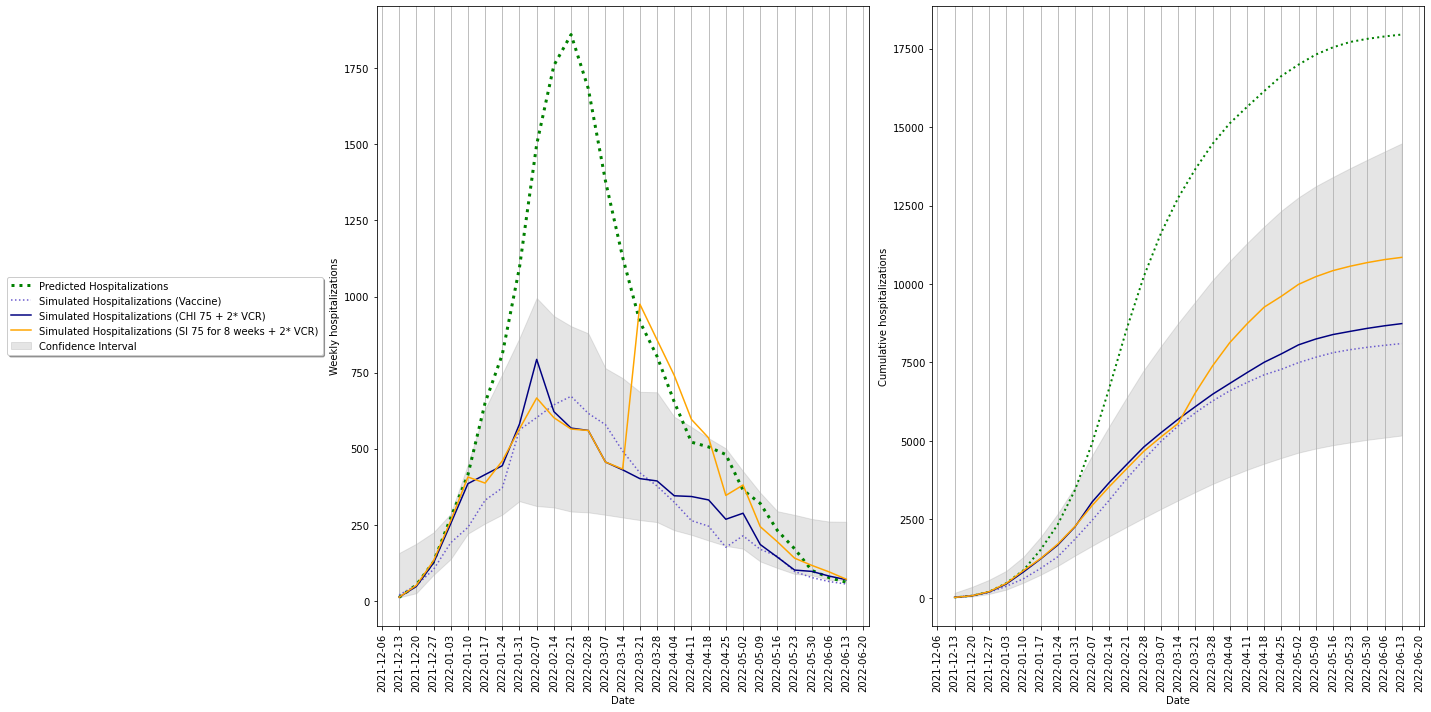

In [56]:

#modified_data2 = modified_data[modified_data['chain']== 'Simulation']
modified_data2 = modified_data[modified_data['chain']== '151']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), dpi=72)
ax1.plot(modified_data2['Date'], modified_data2['weekly_hospitalization'], color="green",linestyle=':', linewidth = 3, label='Predicted Hospitalizations')
ax1.plot(modified_data2['Date'], modified_data2['simulation_LDvac'], c="Slateblue",linestyle=':', label='Simulated Hospitalizations (Vaccine)')
ax1.plot(modified_data2['Date'], modified_data2['predicted_y_SI_new4'], c="navy", label='Simulated Hospitalizations (CHI 75 + 2* VCR)')
#ax1.plot(modified_data2['Date'], modified_data2['ContainmentHealthIndex_Average'], c="red", label='ContainmentHealthIndex')
#ax1.plot(modified_data2['Date'], modified_data2['vcr_uptodate'], c="purple", label='Increased Vaccination coverage')
ax1.plot(modified_data2['Date'], modified_data2['predicted_y_SI_new2'], c="orange", label='Simulated Hospitalizations (SI 75 for 8 weeks + 2* VCR)')
ax1.fill_between(modified_data2['Date'], modified_data2['lower_SI_New4'], modified_data2['upper_SI_New4'], alpha=0.2, color='gray', 
                        label='Confidence Interval')
ax1.legend(loc ='center right', bbox_to_anchor=(-0.1, 0.5), fancybox=True, shadow=True) 
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=1))
ax1.grid(axis='x') 
ax1.set_xlabel('Date') 
ax1.set_ylabel('Weekly hospitalizations')

ax2.plot(modified_data2['Date'], modified_data2['Cumulative_Hospitalization'],linestyle=':', color="green", linewidth = 2, label='Predicted Hospitalizations')
ax2.plot(modified_data2['Date'], modified_data2['Cumu_Hospitalization_LD_vac'], c="Slateblue",linestyle=':', label='Simulations (Distance to Vaccine)')
ax2.plot(modified_data2['Date'], modified_data2['Cumu_Hospitalization_simulated_SI_new4'], c="navy", label='Simulations (CHI 75 + 2* VCR)')
ax2.plot(modified_data2['Date'], modified_data2['Cumu_Hospitalization_simulated_SI_new2'], c="orange", label='Simulations (SI 75 for 8 weeks + 2* VCR)')
ax2.fill_between(modified_data2['Date'], modified_data2['Cumu_lci_SI_new4'], modified_data2['Cumu_uci_SI_new4'], alpha=0.2, color='gray', 
                        label='Confidence Interval')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
# Set major locator to start weeks from Monday 
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=1))
ax2.grid(axis='x') 
ax2.set_xlabel('Date') 
ax2.set_ylabel('Cumulative hospitalizations')


# Rotate date labels for better readability
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)

# Ensure the subplots are the same size
plt.tight_layout()

# Show the plot
plt.show()



In [57]:
modified_data['chain2'] = modified_data['chain']

modified_data['Cumu_Hospitalization_LD_vac'] = modified_data.groupby('chain')['simulation_LDvac'].cumsum()
modified_data['Cumulative_Hospitalization'] = modified_data.groupby('chain')['weekly_hospitalization'].cumsum()
modified_data['Cumu_lower_LDvac'] = modified_data.groupby('chain')['lower_LDvac'].cumsum()
modified_data['Cumu_upper_LDvac'] = modified_data.groupby('chain')['upper_LDvac'].cumsum()
modified_data['Cumu_Hospitalization_simulated_SI_new'] = modified_data.groupby('chain')['predicted_y_SI_new'].cumsum()
modified_data['Cumu_lci_SI_new'] = modified_data.groupby('chain')['lower_SI_New'].cumsum()
modified_data['Cumu_uci_SI_new'] = modified_data.groupby('chain')['upper_SI_New'].cumsum()
modified_data['Cumu_Hospitalization_simulated_SI_newt'] = modified_data.groupby('chain')['predicted_y_SI_newt'].cumsum()
modified_data['Cumu_lci_SI_newt'] = modified_data.groupby('chain')['lower_SI_Newt'].cumsum()
modified_data['Cumu_uci_SI_newt'] = modified_data.groupby('chain')['upper_SI_Newt'].cumsum()
modified_data['Cumu_Hospitalization_simulated_SI_new2'] = modified_data.groupby('chain')['predicted_y_SI_new2'].cumsum()
modified_data['Cumu_lci_SI_new2'] = modified_data.groupby('chain')['lower_SI_New2'].cumsum()
modified_data['Cumu_uci_SI_new2'] = modified_data.groupby('chain')['upper_SI_New2'].cumsum()
modified_data['Cumu_Hospitalization_simulated_SI_new3'] = modified_data.groupby('chain')['predicted_y_SI_new3'].cumsum()
modified_data['Cumu_lci_SI_new3'] = modified_data.groupby('chain')['lower_SI_New3'].cumsum()
modified_data['Cumu_uci_SI_new3'] = modified_data.groupby('chain')['upper_SI_New3'].cumsum()
modified_data['Cumu_Hospitalization_simulated_SI_new3'] = modified_data.groupby('chain')['predicted_y_SI_new3'].cumsum()
modified_data['Cumu_lci_SI_new3'] = modified_data.groupby('chain')['lower_SI_New3'].cumsum()
modified_data['Cumu_uci_SI_new3'] = modified_data.groupby('chain')['upper_SI_New3'].cumsum()

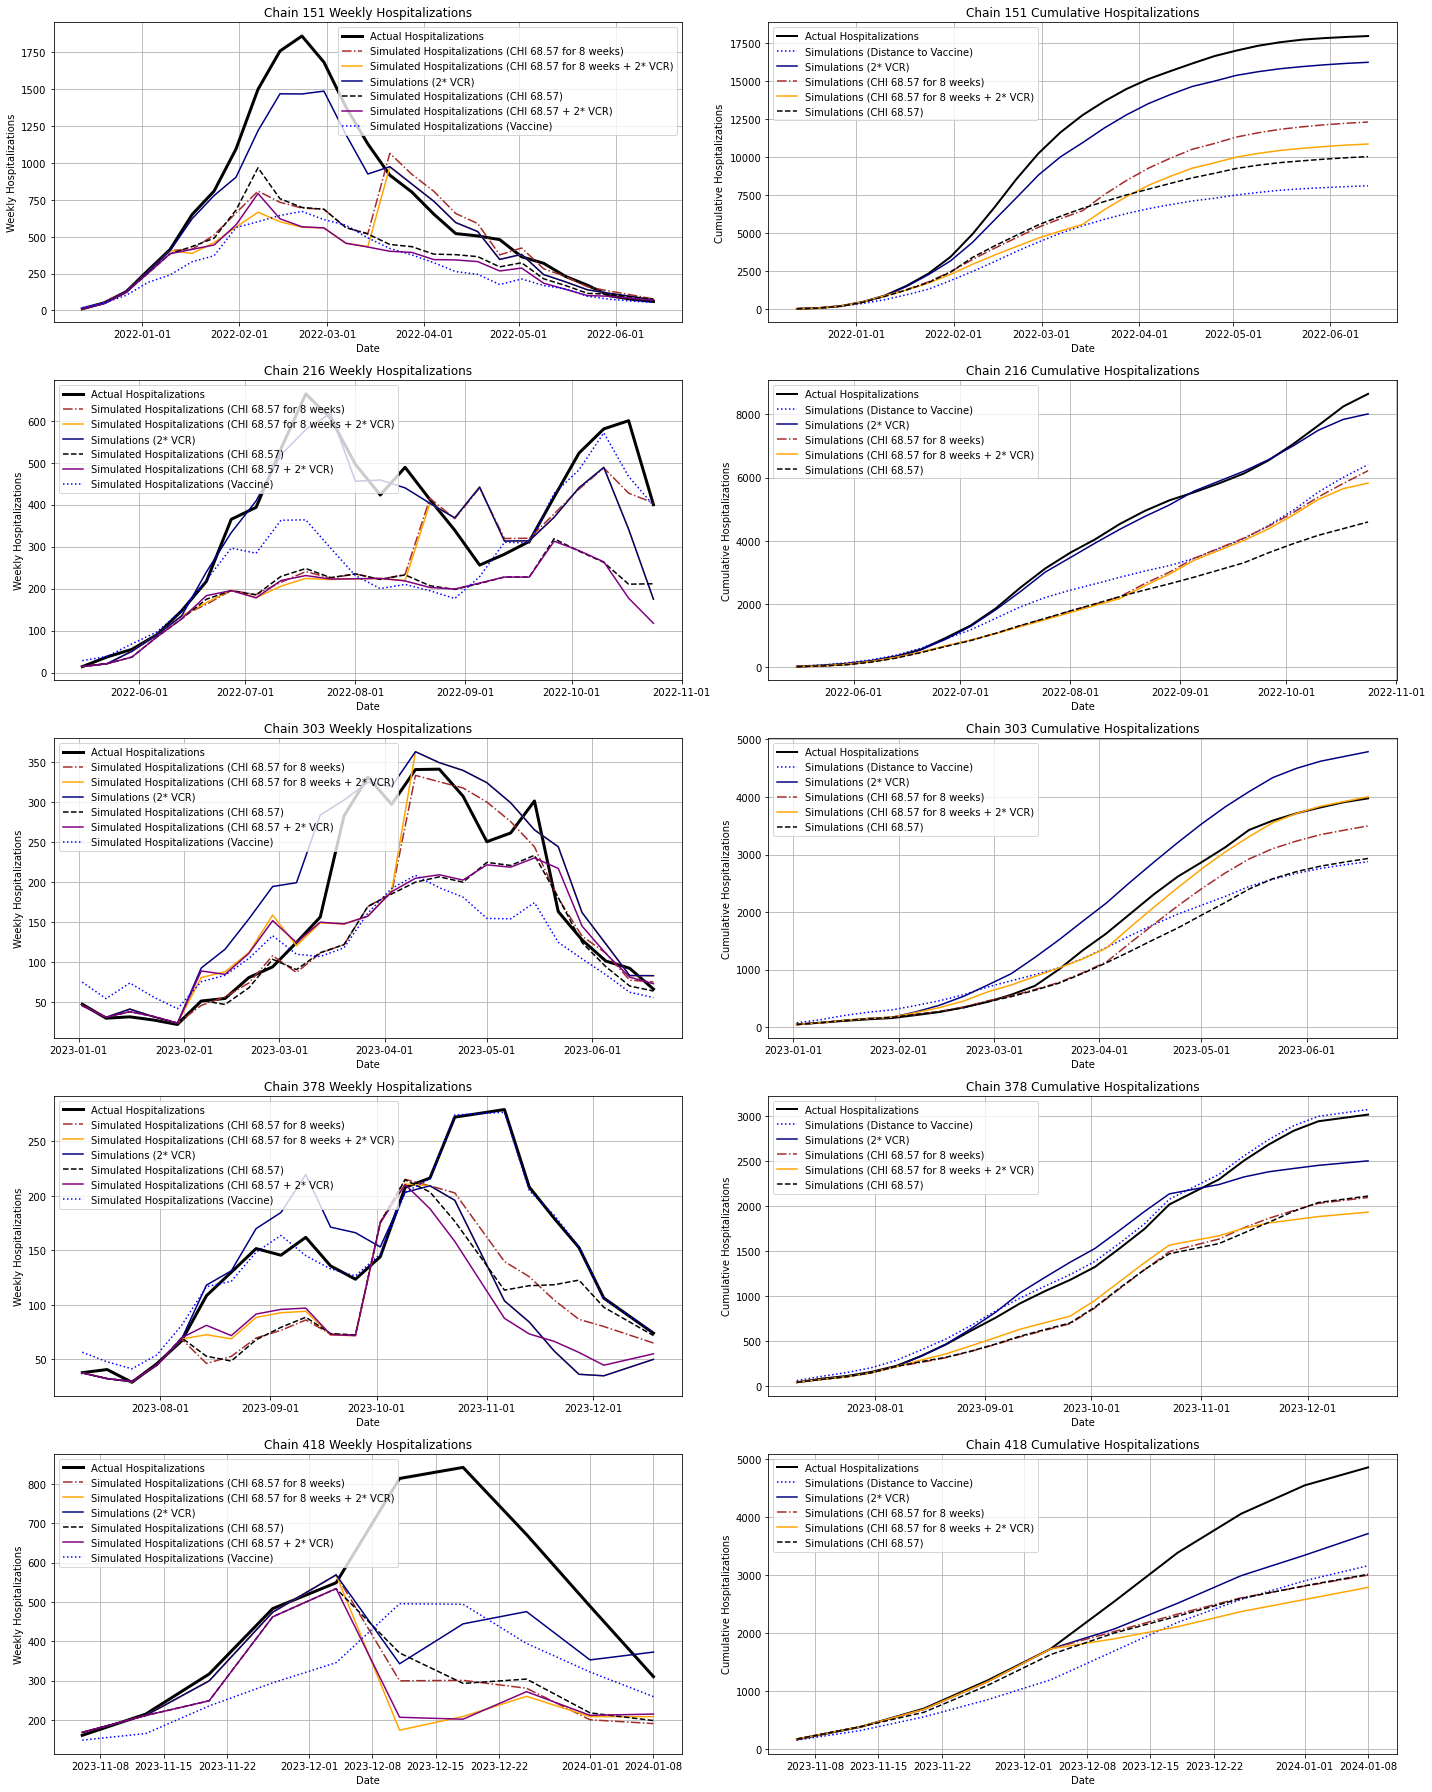

In [58]:
chains_to_plot = [151, 216,303, 378, 418]  # Chains to include
fig, axs = plt.subplots(len(chains_to_plot), 2, figsize=(20, 5 * len(chains_to_plot)), dpi=72)  # Grid layout

for i, chain in enumerate(chains_to_plot):
    # Filter data for the current chain
    chain_data = modified_data[modified_data['chain'] == str(chain)]
    
    # Subplot for weekly hospitalizations
    axs[i, 0].plot(chain_data['Date'], chain_data['weekly_hospitalization'], color="black", linewidth=3, label='Actual Hospitalizations')
    axs[i, 0].plot(chain_data['Date'], chain_data['predicted_y_SI_new'], color="brown", linestyle='-.', label='Simulated Hospitalizations (CHI 68.57 for 8 weeks)')
    axs[i, 0].plot(chain_data['Date'], chain_data['predicted_y_SI_new2'], color="orange", label='Simulated Hospitalizations (CHI 68.57 for 8 weeks + 2* VCR)')
    axs[i, 0].plot(chain_data['Date'], chain_data['predicted_y_SI_new3'], c="navy", label='Simulations (2* VCR)')
    axs[i, 0].plot(chain_data['Date'], chain_data['predicted_y_SI_newt'], c="black",linestyle='--', label='Simulated Hospitalizations (CHI 68.57)')
    axs[i, 0].plot(chain_data['Date'], chain_data['predicted_y_SI_new4'], c="purple", label='Simulated Hospitalizations (CHI 68.57 + 2* VCR)')
    axs[i, 0].plot(chain_data['Date'], chain_data['simulation_LDvac'], c="blue",linestyle=':', label='Simulated Hospitalizations (Vaccine)')
    axs[i, 0].legend(loc='best')
    axs[i, 0].set_title(f'Chain {chain} Weekly Hospitalizations')
    axs[i, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axs[i, 0].set_xlabel('Date')
    axs[i, 0].set_ylabel('Weekly Hospitalizations')
    axs[i, 0].grid(True)
    
    # Subplot for cumulative hospitalizations
    axs[i, 1].plot(chain_data['Date'], chain_data['Cumulative_Hospitalization'], color="black", linewidth=2, label='Actual Hospitalizations')
    #axs[i, 1].plot(chain_data['Date'], chain_data['Cumu_Hospitalization_simulated_2024'], color="green", linestyle=':', linewidth=2, label='Simulated Hospitalizations')
    axs[i, 1].plot(chain_data['Date'], chain_data['Cumu_Hospitalization_LD_vac'], c="blue", linestyle=':',label='Simulations (Distance to Vaccine)')
    axs[i, 1].plot(chain_data['Date'], chain_data['Cumu_Hospitalization_simulated_SI_new3'], c="navy", label='Simulations (2* VCR)')
    axs[i, 1].plot(chain_data['Date'], chain_data['Cumu_Hospitalization_simulated_SI_new'], c="brown",linestyle='-.', label='Simulations (CHI 68.57 for 8 weeks)')
    axs[i, 1].plot(chain_data['Date'], chain_data['Cumu_Hospitalization_simulated_SI_new2'], c="orange", label='Simulations (CHI 68.57 for 8 weeks + 2* VCR)')
    axs[i, 1].plot(chain_data['Date'], chain_data['Cumu_Hospitalization_simulated_SI_newt'], c="black",linestyle='--', label='Simulations (CHI 68.57)')
    #axs[i, 1].plot(chain_data['Date'], chain_data['Cumu_Hospitalization_simulated_SI_new'], color="brown", linestyle='-.', label='Cumulative Simulated Hospitalizations (CHI 75 for 8 weeks)')
    axs[i, 1].legend(loc='best')
    axs[i, 1].set_title(f'Chain {chain} Cumulative Hospitalizations')
    axs[i, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axs[i, 1].set_xlabel('Date')
    axs[i, 1].set_ylabel('Cumulative Hospitalizations')
    axs[i, 1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('hospitalizations_chains.png')
plt.show()


In [59]:
sum_value = modified_data.groupby('chain')[['simulation_LDvac', 'lower_LDvac', 'upper_LDvac']].sum().reset_index()
sum_value = sum_value.rename(columns={
    'simulation_LDvac': 'values',
    'lower_LDvac': 'lower',
    'upper_LDvac': 'upper'
})
sum_value['name'] = 'LDvac'

sum_value2 = modified_data.groupby('chain')[['predicted_y_SI_new', 'lower_SI_New', 'upper_SI_New']].sum().reset_index()  # Correct groupby
sum_value2 = sum_value2.rename(columns={  # Rename columns for sum_value2
    'predicted_y_SI_new': 'values',
    'lower_SI_New': 'lower',
    'upper_SI_New': 'upper'
})
sum_value2['name'] = 'SI_New'

sum_value3 = modified_data.groupby('chain')[['predicted_y_SI_newt', 'lower_SI_Newt', 'upper_SI_Newt']].sum().reset_index()  # Correct groupby
sum_value3 = sum_value3.rename(columns={  # Rename columns for sum_value3
    'predicted_y_SI_newt': 'values',
    'lower_SI_Newt': 'lower',
    'upper_SI_Newt': 'upper'
})
sum_value3['name'] = 'SI_Newt'

sum_value4 = modified_data.groupby('chain')[['predicted_y_SI_new2', 'lower_SI_New2', 'upper_SI_New2']].sum().reset_index()  # Correct groupby
sum_value4 = sum_value4.rename(columns={  # Rename columns for sum_value4
    'predicted_y_SI_new2': 'values',
    'lower_SI_New2': 'lower',
    'upper_SI_New2': 'upper'
})
sum_value4['name'] = 'SI_New2'

sum_value5 = modified_data.groupby('chain')[['predicted_y_SI_new3', 'lower_SI_New3', 'upper_SI_New3']].sum().reset_index()  # Correct groupby
sum_value5 = sum_value5.rename(columns={  # Rename columns for sum_value5
    'predicted_y_SI_new3': 'values',
    'lower_SI_New3': 'lower',
    'upper_SI_New3': 'upper'
})
sum_value5['name'] = 'SI_New3'

sum_value6 = modified_data.groupby('chain')[['predicted_y_SI_new4', 'lower_SI_New4', 'upper_SI_New4']].sum().reset_index()  # Correct groupby
sum_value6 = sum_value6.rename(columns={  # Rename columns for sum_value6
    'predicted_y_SI_new4': 'values',
    'lower_SI_New4': 'lower',
    'upper_SI_New4': 'upper'
})
sum_value6['name'] = 'SI_New4'

sum_value7 = modified_data.groupby('chain')[['weekly_hospitalization']].sum().reset_index()  # Correct groupby
sum_value7 = sum_value7.rename(columns={  # Rename columns for sum_value7
    'weekly_hospitalization': 'values'
})
sum_value7['name'] = 'weekly_hospitalization'

#sum_value8 = modified_data.groupby('chain')[['simulation_2024']].sum().reset_index()  # Correct groupby
#sum_value8 = sum_value8.rename(columns={  # Rename columns for sum_value8
#    'simulation_2024': 'values'
#})
#sum_value8['name'] = 'simulation_2024'



combined_df = pd.concat([sum_value, sum_value2, sum_value3, sum_value4, sum_value5, sum_value6, sum_value7], ignore_index=True)
print(combined_df)

   chain       values        lower         upper                    name
0    100   244.544930    68.549882    628.620235                   LDvac
1    105   705.308902   465.291886   1099.304426                   LDvac
2    123  2366.287186  1656.034980   3188.144378                   LDvac
3    125  1208.477137   664.022395   1299.983427                   LDvac
4    151  8101.099708  5005.957123  13090.310459                   LDvac
..   ...          ...          ...           ...                     ...
93    29  6777.914045          NaN           NaN  weekly_hospitalization
94   303  3976.101181          NaN           NaN  weekly_hospitalization
95   378  3018.459987          NaN           NaN  weekly_hospitalization
96   418  4850.901173          NaN           NaN  weekly_hospitalization
97    53  2985.172017          NaN           NaN  weekly_hospitalization

[98 rows x 5 columns]


In [60]:
name_mapping = {
    'LDvac': 'Closer vaccine strain',  
    'SI_New': 'CHI 68.57 for 8 weeks',  
    'SI_Newt': 'CHI 68.57',  
    'SI_New2': 'CHI 68.57 for 8 weeks + 2* VCR',  
    'SI_New3': '2* VCR',  
    'SI_New4': 'CHI 68.57 + 2* VCR',  
    'weekly_hospitalization': 'Hospitalizations'#,  
    #'simulation_2024': 'Simulation'  
}

combined_df['name2'] = combined_df['name'].map(name_mapping)

In [61]:
# Extract required columns and rename `values` to `actual`
sum_value7_modified = sum_value7[['chain', 'values']].rename(columns={'values': 'actual'})

# Merge the modified sum_value7 with df
#df = df.merge(sum_value7_modified, on='chain', how='left')
combined_df = combined_df.merge(sum_value7_modified, on='chain', how='left')

print(combined_df)

   chain       values        lower         upper                    name  \
0    100   244.544930    68.549882    628.620235                   LDvac   
1    105   705.308902   465.291886   1099.304426                   LDvac   
2    123  2366.287186  1656.034980   3188.144378                   LDvac   
3    125  1208.477137   664.022395   1299.983427                   LDvac   
4    151  8101.099708  5005.957123  13090.310459                   LDvac   
..   ...          ...          ...           ...                     ...   
93    29  6777.914045          NaN           NaN  weekly_hospitalization   
94   303  3976.101181          NaN           NaN  weekly_hospitalization   
95   378  3018.459987          NaN           NaN  weekly_hospitalization   
96   418  4850.901173          NaN           NaN  weekly_hospitalization   
97    53  2985.172017          NaN           NaN  weekly_hospitalization   

                    name2        actual  
0   Closer vaccine strain    246.590690  
1  

In [62]:
combined_df['percent_reduction'] = ((combined_df['values'] - combined_df['actual'] ) / combined_df['actual']) * 100
combined_df['percent_reduction_lci'] = ((combined_df['lower'] - combined_df['actual']) / combined_df['actual']) * 100
combined_df['percent_reduction_uci'] = ((combined_df['upper'] - combined_df['actual']) / combined_df['actual']) * 100
print(combined_df)

   chain       values        lower         upper                    name  \
0    100   244.544930    68.549882    628.620235                   LDvac   
1    105   705.308902   465.291886   1099.304426                   LDvac   
2    123  2366.287186  1656.034980   3188.144378                   LDvac   
3    125  1208.477137   664.022395   1299.983427                   LDvac   
4    151  8101.099708  5005.957123  13090.310459                   LDvac   
..   ...          ...          ...           ...                     ...   
93    29  6777.914045          NaN           NaN  weekly_hospitalization   
94   303  3976.101181          NaN           NaN  weekly_hospitalization   
95   378  3018.459987          NaN           NaN  weekly_hospitalization   
96   418  4850.901173          NaN           NaN  weekly_hospitalization   
97    53  2985.172017          NaN           NaN  weekly_hospitalization   

                    name2        actual  percent_reduction  \
0   Closer vaccine strain

In [63]:
result = modified_data.groupby('chain')['CHI_lagged2'].agg(
    average_CHI_lagged='mean',
    max_CHI_lagged='max'
).reset_index()
merged_df = pd.merge(combined_df, result, on='chain', how='left')
result2 = modified_data.groupby('chain')['vcr_lagged2'].agg(
    max_vcr_lagged='max'
).reset_index()

merged_df = pd.merge(merged_df, result2, on='chain', how='left')

result3 = modified_data.groupby('chain')['LD1'].agg(
    LD1='max'
).reset_index()

merged_df = pd.merge(merged_df, result3, on='chain', how='left')

result4 = modified_data.groupby('chain')['LD_vac2'].agg(
    LDvac='max'
).reset_index()

merged_df = pd.merge(merged_df, result4, on='chain', how='left')

print(merged_df)

   chain       values        lower         upper                    name  \
0    100   244.544930    68.549882    628.620235                   LDvac   
1    105   705.308902   465.291886   1099.304426                   LDvac   
2    123  2366.287186  1656.034980   3188.144378                   LDvac   
3    125  1208.477137   664.022395   1299.983427                   LDvac   
4    151  8101.099708  5005.957123  13090.310459                   LDvac   
..   ...          ...          ...           ...                     ...   
93    29  6777.914045          NaN           NaN  weekly_hospitalization   
94   303  3976.101181          NaN           NaN  weekly_hospitalization   
95   378  3018.459987          NaN           NaN  weekly_hospitalization   
96   418  4850.901173          NaN           NaN  weekly_hospitalization   
97    53  2985.172017          NaN           NaN  weekly_hospitalization   

                    name2        actual  percent_reduction  \
0   Closer vaccine strain

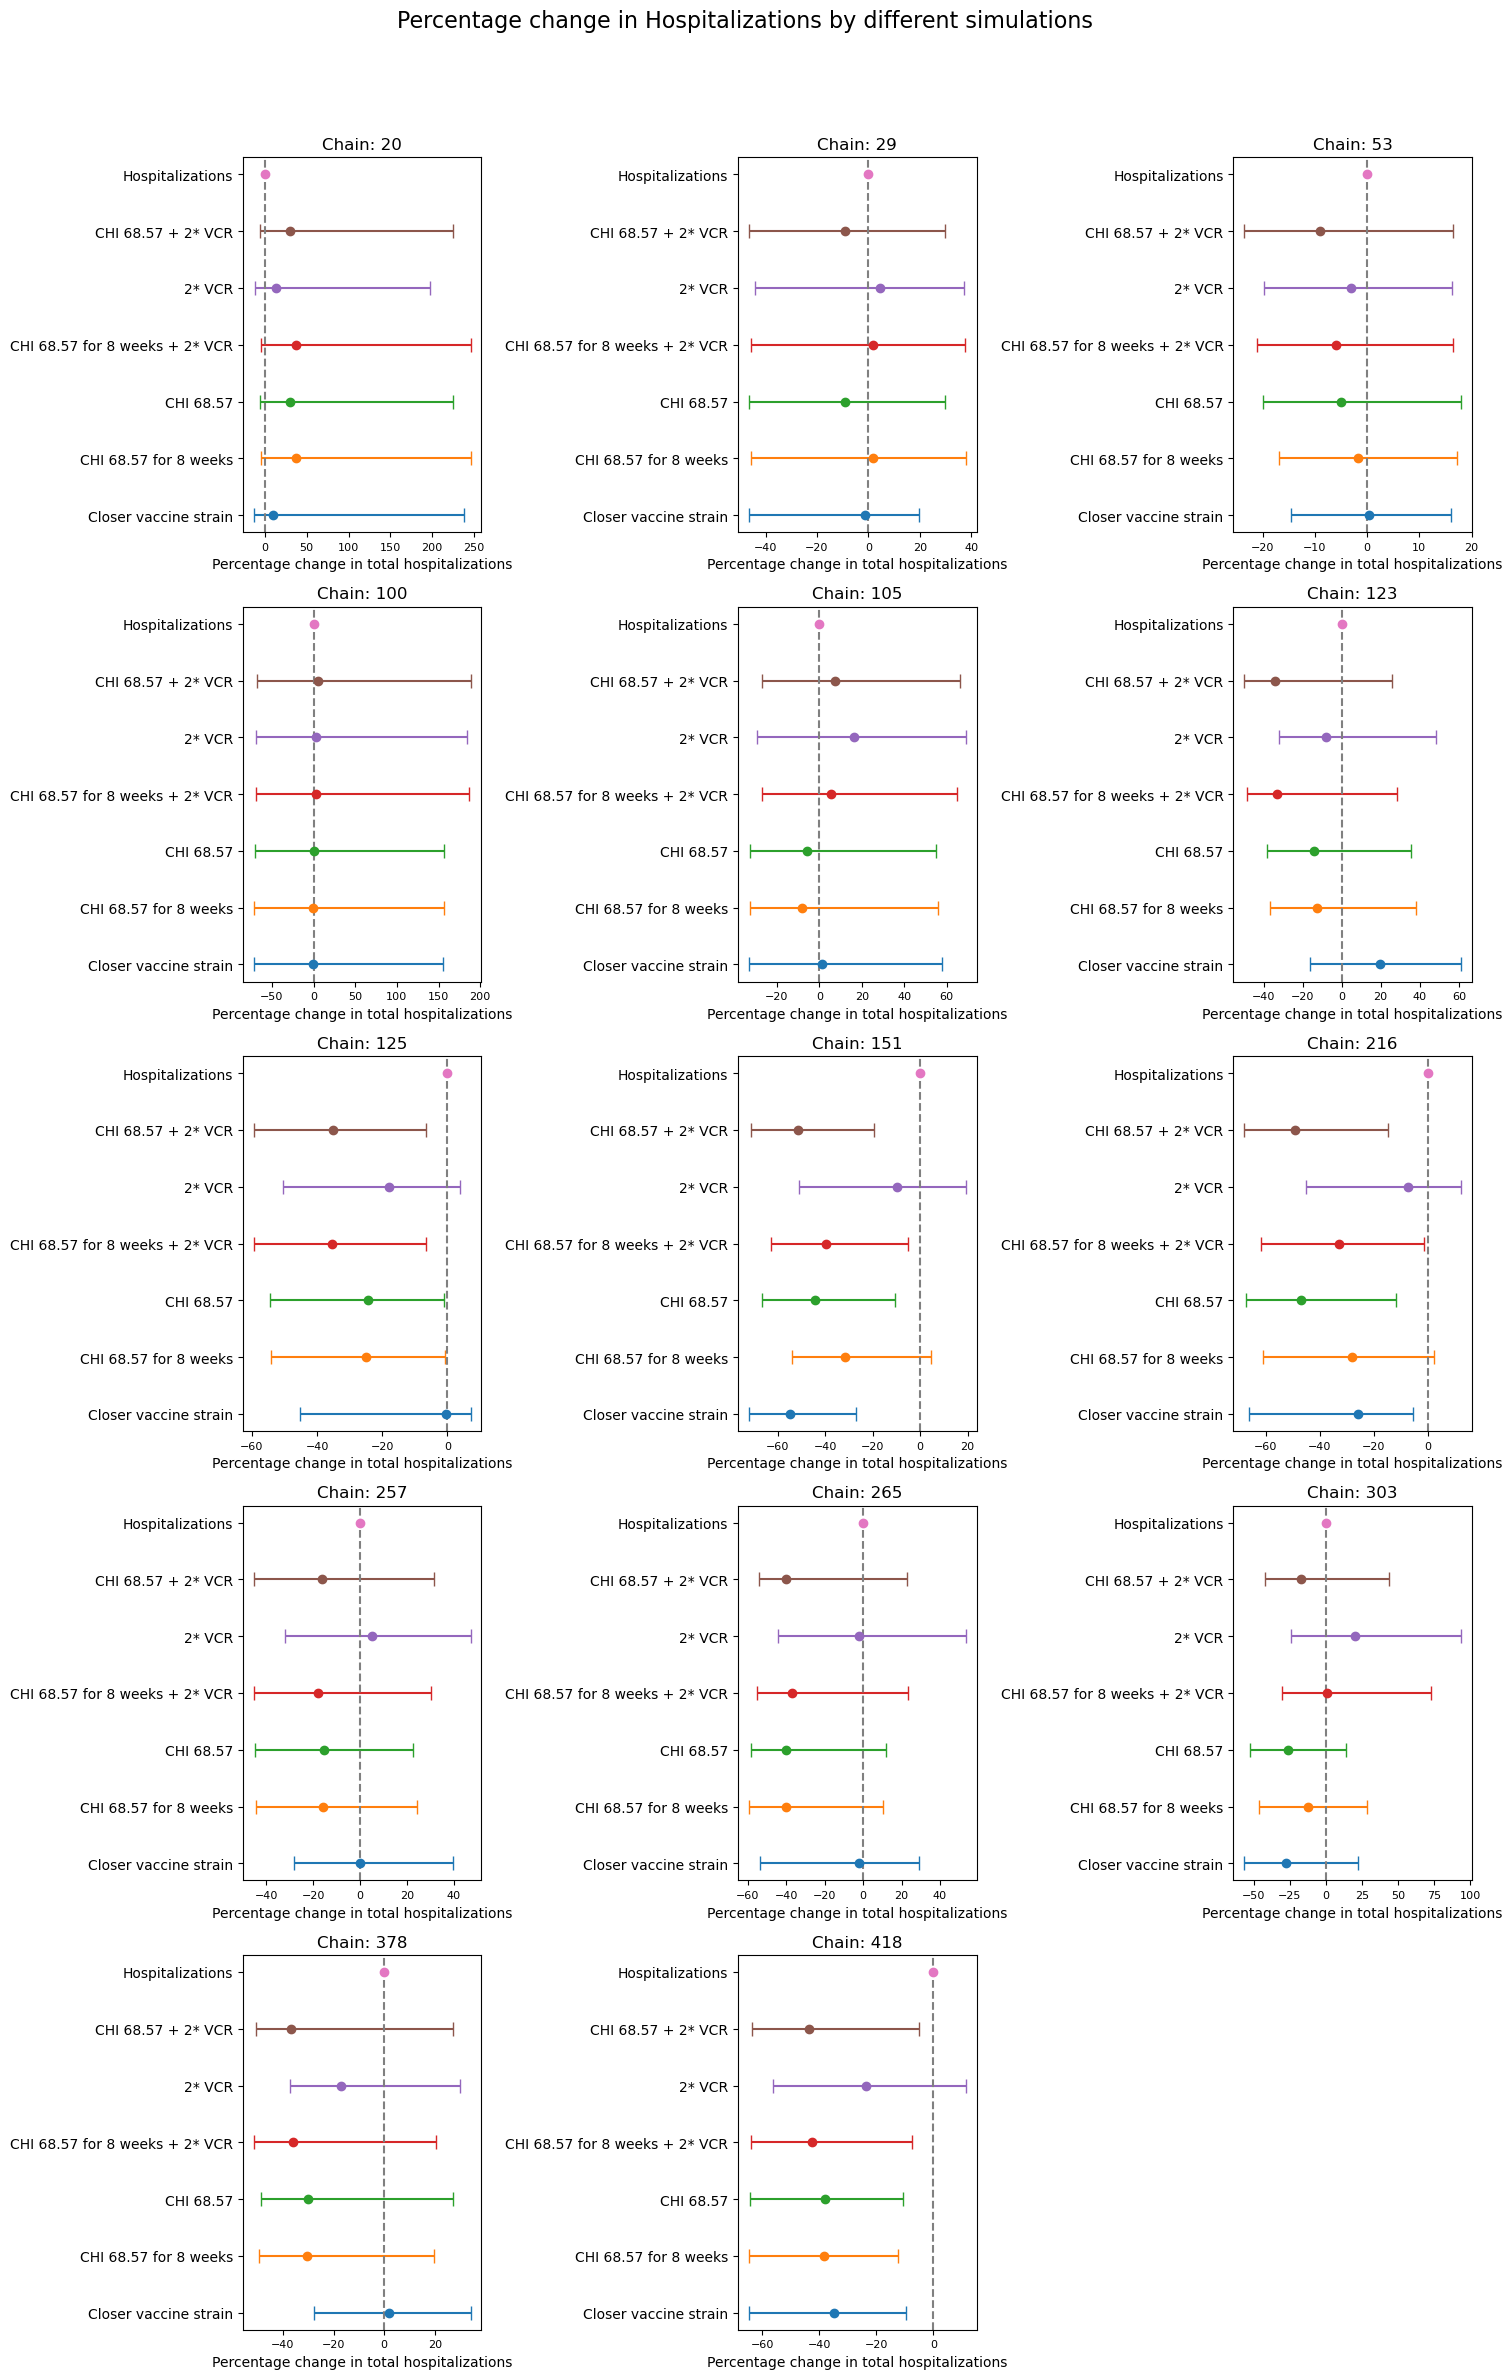

In [64]:
# Calculate the number of rows and columns for the subplots grid
ncols = 3  # Adjust as needed
nrows = (len(chains) + ncols - 1) // ncols  # Calculate rows dynamically

# Create the figure and subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5*nrows), dpi=100) #sharex for the same x axis

# Flatten the axes array for easier iteration (if needed)
if isinstance(axes, np.ndarray): #If there are more than 1 subplot
    axes = axes.flatten()
else:
    axes = [axes] #If there is only one subplot, make it a list

# Iterate over each unique 'chain' value and plot on separate subplots
for i, chain_val in enumerate(chains):
    ax = axes[i]  # Select the correct subplot axes

    chain_df = combined_df[combined_df['chain'] == chain_val]

    for name2_val in chain_df['name2'].unique():
        subset = chain_df[chain_df['name2'] == name2_val]
        ax.errorbar(subset['percent_reduction'], subset['name2'],
                     xerr=[subset['percent_reduction'] - subset['percent_reduction_lci'], subset['percent_reduction_uci'] - subset['percent_reduction']],
                     fmt='o', capsize=5, label=name2_val)  # Label without chain

    # Add vertical line for 'simulation_2024' (if it exists for this chain)
    simulation_2024_val = subset[subset['name'] == 'weekly_hospitalization']['percent_reduction'].values
    if len(simulation_2024_val) > 0:  # Check if it exists
        ax.axvline(x=simulation_2024_val[0], linestyle='--', color='gray', label='Actual')

    ax.set_xlabel('Percentage change in total hospitalizations')
    ax.set_title(f'Chain: {chain_val}')  # Title for each subplot
    #ax.legend(fontsize='small') #Legend for each subplot
    ax.tick_params(axis='x', labelsize=8) #Adjust x label size

# Hide any unused subplots
for j in range(i + 1, len(axes)):  # Hide empty subplots
    axes[j].set_axis_off()

fig.suptitle('Percentage change in Hospitalizations by different simulations', fontsize=16) #Overall title for the figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap with suptitle
plt.savefig('hospitalizations_pct2.png')
plt.show()

In [66]:
name_to_sim = {
    'Closer vaccine strain': 'Simulation 1 - better-matched vaccine strain',
    'CHI 68.57': 'Simulation 2 - sustained high CHI',
    'CHI 68.57 for 8 weeks': 'Simulation 3 - temporary high CHI',
    '2* VCR': 'Simulation 4 - doubling Vaccination Coverage (VCR)',
    'CHI 68.57 + 2* VCR': 'Simulation 5 - sustained high CHI + doubling VCR',
    'CHI 68.57 for 8 weeks + 2* VCR': 'Simulation 6 - temporary high CHI + doubling VCR',
    'Hospitalizations': 'Hospitalizations'
}
# Apply the mapping
combined_df['Simulation'] = combined_df['name2'].map(name_to_sim)
count_table = combined_df.groupby(['name2', 'Simulation']).size().reset_index(name='Count')
count_table = count_table[count_table['Count'] > 0]

print(count_table)

                            name2  \
0                          2* VCR   
1                       CHI 68.57   
2              CHI 68.57 + 2* VCR   
3           CHI 68.57 for 8 weeks   
4  CHI 68.57 for 8 weeks + 2* VCR   
5           Closer vaccine strain   
6                Hospitalizations   

                                          Simulation  Count  
0  Simulation 4 - doubling Vaccination Coverage (...     14  
1                  Simulation 2 - sustained high CHI     14  
2   Simulation 5 - sustained high CHI + doubling VCR     14  
3                  Simulation 3 - temporary high CHI     14  
4   Simulation 6 - temporary high CHI + doubling VCR     14  
5       Simulation 1 - better-matched vaccine strain     14  
6                                   Hospitalizations     14  


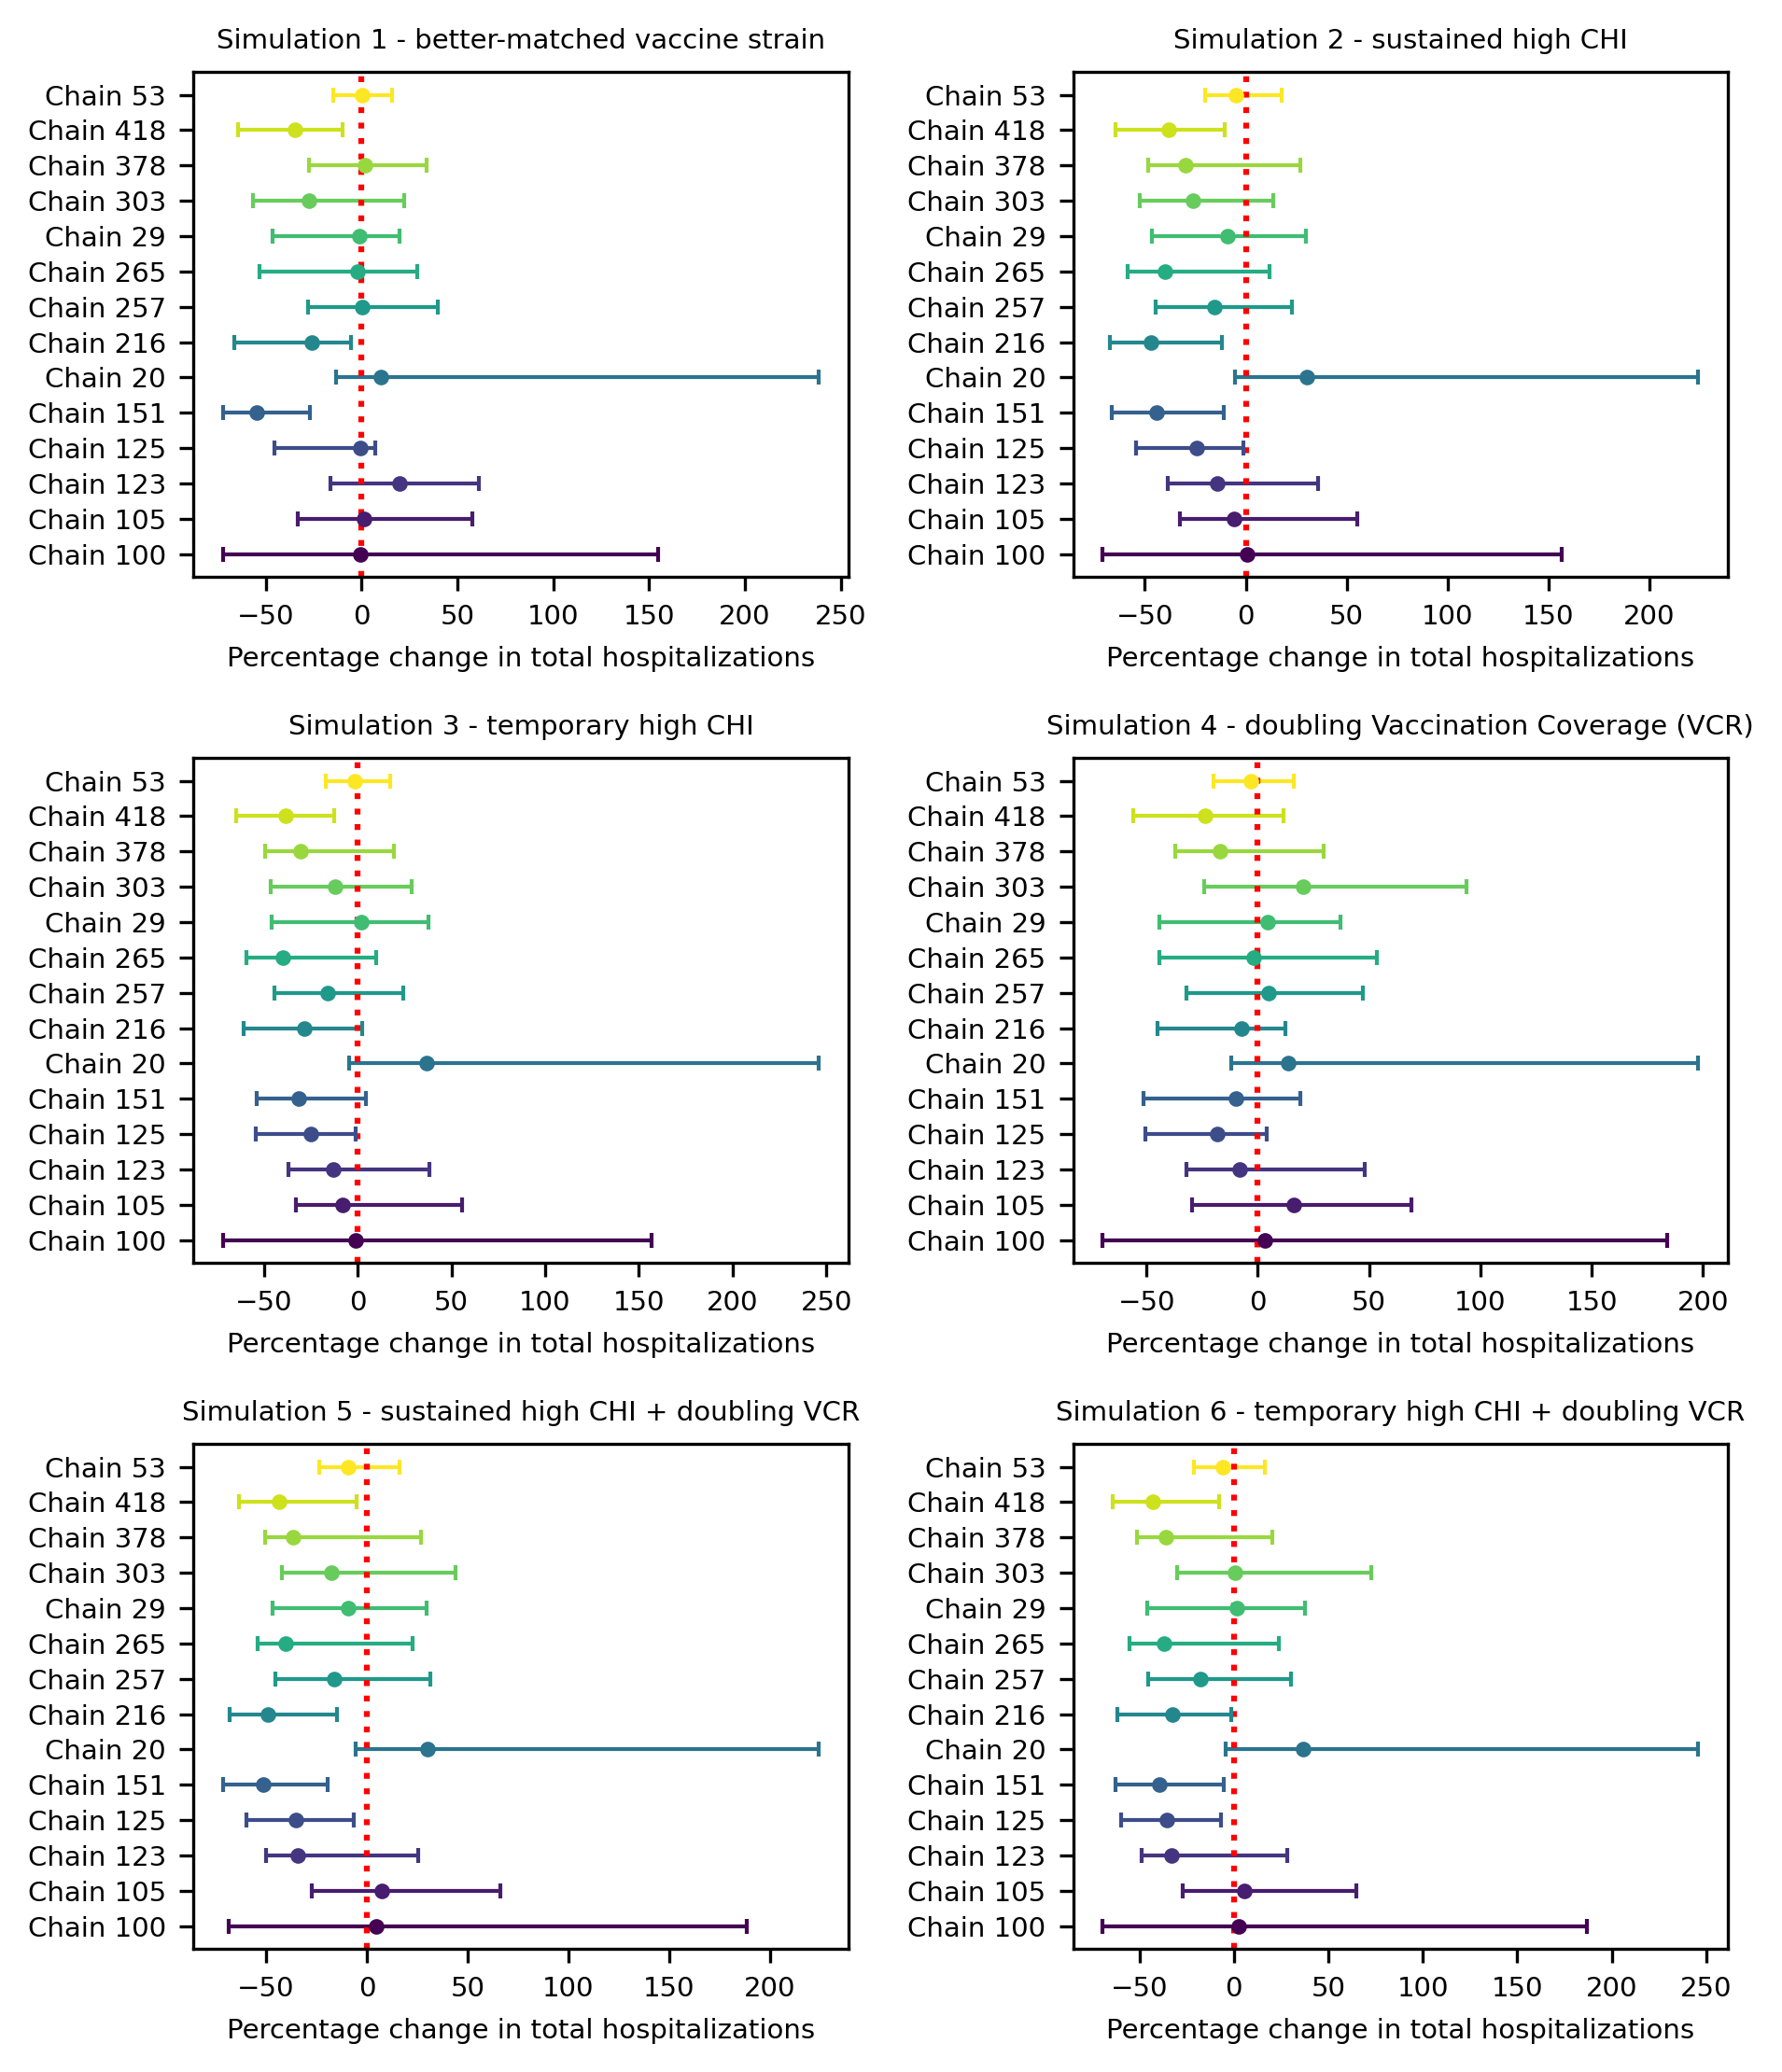

In [67]:
df = combined_df[combined_df['name2'] != 'Hospitalizations']

# Get unique name2 values
name2_values = sorted(df['Simulation'].unique())
# Get unique chain values for coloring
chains = sorted(df['chain'].unique())

def forward(x):
    return np.where(x <= 75, x, 75 + np.log10(x - 74))

# Create a numerical mapping for the y-axis
chain_to_y = {chain: i for i, chain in enumerate(chains)}

chain_colors = plt.cm.viridis(np.linspace(0, 1, len(chains)))
color_map = dict(zip(chains, chain_colors))

# Calculate the number of rows and columns for the subplots grid
ncols = 2
nrows = (len(name2_values) + ncols - 1) // ncols

tick_positions = [-75,-50, -25, 0, 25, 50, 75, 200]
tick_labels = ['-75%','-50%','-25%', '0','25%', '50%', '75%','200%']

# Create the figure and subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7.5, 2.5*nrows), dpi=300)
axes = axes.flatten()

# Collect handles and labels for a single legend
handles, labels = [], []

# Iterate over each unique 'name2' value and plot on a separate subplot
for i, name2_val in enumerate(name2_values):
    ax = axes[i]
    name2_df = df[df['Simulation'] == name2_val]
    # Add vertical red dotted line at x = 0
    ax.axvline(x=0, color='red', linestyle='dotted')

    # Plot error bars for each chain within the current 'name2' subplot
    for chain_val in chains:
        chain_df = name2_df[name2_df['chain'] == chain_val]

        if not chain_df.empty:
            ax.errorbar(
                chain_df['percent_reduction'],
                [chain_to_y[chain_val]] * len(chain_df),  # Use numerical y-value
                xerr=[chain_df['percent_reduction'] - chain_df['percent_reduction_lci'],
                      chain_df['percent_reduction_uci'] - chain_df['percent_reduction']],
                fmt='o',
                capsize=2,
                elinewidth=1, 
                ms=3,  
                color=color_map[chain_val],
                label=f'Chain {chain_val}' if i == 0 else ''  # Label only for the first subplot
            )
    
    ax.set_title(f'{name2_val}', fontsize=7)
    ax.set_xlabel('Percentage change in total hospitalizations', fontsize=7)
    
    #ax.set_xscale('function', functions=(forward, np.log2))  # Apply forward transformation
    #ax.set_xticks(tick_positions)
    #ax.set_xticklabels(tick_labels, fontsize=4, rotation=90)
    # Set y-ticks to the numerical positions and y-tick labels to the chain names
    ax.set_yticks(list(chain_to_y.values()))
    ax.set_yticklabels([f'Chain {c}' for c in chains], fontsize=7)
    
    ax.tick_params(axis='x', labelsize=7)
    #ax.set_xlim(-70, 70)
    

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_axis_off()

# Create a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
unique_labels = list(dict.fromkeys(labels))
unique_handles = [handles[labels.index(l)] for l in unique_labels]

#fig.legend(unique_handles, unique_labels, loc='center right', ncol=1, fontsize=12)

#fig.suptitle('Percentage change in Hospitalizations by different simulations', fontsize=8, y=1.01)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for the legend

# Add figure description as text at the bottom
#fig.text(0.5, -0.02, "Figure 6. Changes in the proportion of total hospitalizations per chain in Denmark,\nacross different scenarios, with respective 95 % confidence intervals.",
#         ha='center', va='bottom', fontsize=8)
plt.savefig('Figure 6.svg', format='svg', bbox_inches='tight')
plt.show()

In [ ]:
#modified_data.to_csv('modified_data.csv', index=False)
#merged_df.to_csv('results_data.csv', index=False)